# March Machine Learning Madness 2024
### Predicting NCAA Basketball Tournament Results
##### From the [Kaggle Competition: "March Machine Learning Mania 2024"](https://www.kaggle.com/competitions/march-machine-learning-mania-2024/overview)
##### By David Hartsman

<div class="alert alert-block alert-info" style="font-size: 1em; background-color:blue; color:white";>
<b>Modeling Notebook:</b> Feature Engineering, Model Iterations, and Evaluation 
</div>

### Overview:
In the previous notebook, I prepared data by selecting elements from over 30 different file sources. In this notebook, I will use that data to begin training models with the purpose of correctly predicting NCAA Tournament games. There are 4 different potential target values I could use to train models:

- Binary W/L Target
- Continuous Team_A Pts Scored
- Continuous Team_B Pts Scored
- Continuous Team_A - Team_B Pts Differential

I will use this notebook by to build a successful classification model using algorithms from the Scikit-Learn Library. I will be comparing the performance of the model against the performance of "dummy logic". This logic will select the winner by choosing the better (lower) of the two teams' Chalk Seeds, and if the seeds are the same, the logic will choose the team with the better overall winning percentage. This may sound like a low bar to clear, but due to the small number of observations, this task may actually prove quite difficult. 

<hr style="border: 4px solid blue">

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import warnings
warnings.filterwarnings("ignore")

# Sklearn Accessories
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, auc, roc_curve, \
roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector

# Model Types
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier,\
GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from classification_classes import Model, compare_curves

import xgboost
from xgboost import XGBClassifier


pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', None)
sns.set_style("darkgrid")

<div class="alert alert-block alert-info" style="font-size: 2em;">
<b>Model Creation:</b> Final Feature Curation
</div>

After loading in the data, I will take a few final steps to prepare the data for modeling. I will select the features that I would like to use. As a starting point, I will opt to use as many features as possible, and subsequently weed out any features that may not be contributing much signal. 

I will also be creating "dummy" predictions. These predictions will be created by:

- A.) Choosing the lower of the 2 "Chalk_Seeds" as the winner, and
- B.) If the seeds are the same, choosing the team with the better winning percentage

These predictions are equivalent to picking *"chalk"*, or the on-paper favorite in every match-up without the benefit of any additional analysis. 

After that, I will perform a train-test split and create an sklearn pipeline to handle pre-modeling transformations such as *scaling* and *one-hot-encoding*. Then, utilize a class-object that I have created to store the results and metrics of different model iterations. 

In [2]:
# Load in data

# Create a path reference for easier readability 
path = '/Users/samalainabayeva/Desktop/FLAT_IRON!!!/NCAA_KAGGLE/march-machine-learning-mania-2024/'

# Load and inspect the data
df = pd.read_csv(os.path.join(path, 'Data_For_Modeling.csv'), index_col=0)
df.head()

,DayNum,League,Season,Team_A_Avg3ptAtt,Team_A_Avg3ptMade,Team_A_AvgFGAtt,Team_A_AvgFGMade,Team_A_AvgOppScore,Team_A_AvgPtDiff,Team_A_AvgTeamScore,Team_A_Avg_Assts,Team_A_Avg_Blocks,Team_A_Avg_Def_Rebs,Team_A_Avg_FT_Att,Team_A_Avg_FT_Made,Team_A_Avg_Fouls,Team_A_Avg_Off_Rebs,Team_A_Avg_Steals,Team_A_Avg_TO,Team_A_BestRanking,Team_A_Chalk_Seed,Team_A_CloseGames,Team_A_CloseWins,Team_A_Coach,Team_A_Conference,Team_A_DiffTrend,Team_A_HomeLoss,Team_A_HomeWins,Team_A_LastFivePtDiff,Team_A_LastFiveWinPerc,Team_A_LastTenPtDiff,Team_A_LastTenWinPerc,Team_A_Loc,Team_A_Loss_Total,Team_A_MaxLStreak,Team_A_MaxWStreak,Team_A_MedPtDiff,Team_A_MedianRanking,Team_A_NeutralLoss,Team_A_NeutralWins,Team_A_OTLoss,Team_A_OTWins,Team_A_OppAvg3ptAtt,Team_A_OppAvg3ptMade,Team_A_OppAvgFGAtt,Team_A_OppAvgFGMade,Team_A_OppAvg_Assts,Team_A_OppAvg_Blocks,Team_A_OppAvg_Def_Rebs,Team_A_OppAvg_FT_Att,Team_A_OppAvg_FT_Made,Team_A_OppAvg_Fouls,Team_A_OppAvg_Off_Rebs,Team_A_OppAvg_Steals,Team_A_OppAvg_TO,Team_A_OppTotal3ptAtt,Team_A_OppTotal3ptMade,Team_A_OppTotalFGAtt,Team_A_OppTotalFGMade,Team_A_OppTotal_Assts,Team_A_OppTotal_Def_Rebs,Team_A_OppTotal_FT_Att,Team_A_OppTotal_FT_Made,Team_A_OppTotal_Off_Rebs,Team_A_OppTotal_TO,Team_A_Relative_Diff_Trend,Team_A_Relative_Win_Trend,Team_A_RoadLoss,Team_A_RoadWins,Team_A_Score,Team_A_Seed,Team_A_StdDevOppScore,Team_A_StdDevTeamScore,Team_A_StdPtDiff,Team_A_TeamID,Team_A_Total3ptAtt,Team_A_Total3ptMade,Team_A_TotalFGAtt,Team_A_TotalFGMade,Team_A_Total_Assts,Team_A_Total_Def_Rebs,Team_A_Total_FT_Att,Team_A_Total_FT_Made,Team_A_Total_Off_Rebs,Team_A_Total_TO,Team_A_WinTrend,Team_A_Win_Total,Team_A_WorstRanking,Team_A_close_game_win_perc,Team_A_home_win_perc,Team_A_neutral_win_perc,Team_A_ot_win_perc,Team_A_road_win_perc,Team_A_win_perc,Team_B_Avg3ptAtt,Team_B_Avg3ptMade,Team_B_AvgFGAtt,Team_B_AvgFGMade,Team_B_AvgOppScore,Team_B_AvgPtDiff,Team_B_AvgTeamScore,Team_B_Avg_Assts,Team_B_Avg_Blocks,Team_B_Avg_Def_Rebs,Team_B_Avg_FT_Att,Team_B_Avg_FT_Made,Team_B_Avg_Fouls,Team_B_Avg_Off_Rebs,Team_B_Avg_Steals,Team_B_Avg_TO,Team_B_BestRanking,Team_B_Chalk_Seed,Team_B_CloseGames,Team_B_CloseWins,Team_B_Coach,Team_B_Conference,Team_B_DiffTrend,Team_B_HomeLoss,Team_B_HomeWins,Team_B_LastFivePtDiff,Team_B_LastFiveWinPerc,Team_B_LastTenPtDiff,Team_B_LastTenWinPerc,Team_B_Loc,Team_B_Loss_Total,Team_B_MaxLStreak,Team_B_MaxWStreak,Team_B_MedPtDiff,Team_B_MedianRanking,Team_B_NeutralLoss,Team_B_NeutralWins,Team_B_OTLoss,Team_B_OTWins,Team_B_OppAvg3ptAtt,Team_B_OppAvg3ptMade,Team_B_OppAvgFGAtt,Team_B_OppAvgFGMade,Team_B_OppAvg_Assts,Team_B_OppAvg_Blocks,Team_B_OppAvg_Def_Rebs,Team_B_OppAvg_FT_Att,Team_B_OppAvg_FT_Made,Team_B_OppAvg_Fouls,Team_B_OppAvg_Off_Rebs,Team_B_OppAvg_Steals,Team_B_OppAvg_TO,Team_B_OppTotal3ptAtt,Team_B_OppTotal3ptMade,Team_B_OppTotalFGAtt,Team_B_OppTotalFGMade,Team_B_OppTotal_Assts,Team_B_OppTotal_Def_Rebs,Team_B_OppTotal_FT_Att,Team_B_OppTotal_FT_Made,Team_B_OppTotal_Off_Rebs,Team_B_OppTotal_TO,Team_B_Relative_Diff_Trend,Team_B_Relative_Win_Trend,Team_B_RoadLoss,Team_B_RoadWins,Team_B_Score,Team_B_Seed,Team_B_StdDevOppScore,Team_B_StdDevTeamScore,Team_B_StdPtDiff,Team_B_TeamID,Team_B_Total3ptAtt,Team_B_Total3ptMade,Team_B_TotalFGAtt,Team_B_TotalFGMade,Team_B_Total_Assts,Team_B_Total_Def_Rebs,Team_B_Total_FT_Att,Team_B_Total_FT_Made,Team_B_Total_Off_Rebs,Team_B_Total_TO,Team_B_WinTrend,Team_B_Win_Total,Team_B_WorstRanking,Team_B_close_game_win_perc,Team_B_home_win_perc,Team_B_neutral_win_perc,Team_B_ot_win_perc,Team_B_road_win_perc,Team_B_win_perc,Team_A_Win,Game_Point_Differential
1136,134,Men,2003,18.500000,5.933333,55.266667,24.733333,70.833333,1.966667,72.800000,14.200000,2.233333,24.800000,28.066667,17.400000,18.300000,13.166667,6.433333,15.233333,233.0,16.0,14.0,9.0,NaN,swac,Uptrend,3.0,11.0,7.2,0.570331,0.5,0.568849,N,12.0,6.0,8.0,2.5,259.0,1.0,3.0,0.0,1.0,23.166667,7.533333,60.400000,25.666667,13.766667,2.600000,22.866667,18.733333,11.966667,21.633333,11.933333,8.000000,14.333333,695.0,226.0,1812.0,770.0,41

In [3]:
df.shape

(2583, 187)

<hr style="border: 2px solid blue">

### Creating Dummy Predictions

In [4]:
# Inspecting the criteria for generating dummy predictions 

df[["Team_A_Chalk_Seed", 'Team_B_Chalk_Seed', "Team_A_win_perc", 'Team_B_win_perc']].head()

,Team_A_Chalk_Seed,Team_B_Chalk_Seed,Team_A_win_perc,Team_B_win_perc
1136,16.0,16.0,0.600000,0.448276
1137,1.0,16.0,0.892857,0.655172
1138,10.0,7.0,0.620690,0.793103
1139,6.0,11.0,0.878788,0.793103
1140,9.0,8.0,0.600000,0.724138


In [248]:
# Function to get dummy predictions

def get_dummy_preds(data):
    """
    Function designed to generate predictions for matchups based only on Team Seeds and Win Percentages
    
    Parameters
    --------------
    data: pandas.DataFrame | dataframe containing the relevant feature columns
        Team_A_Chalk_Seed, Team_B_Chalk_Seed, Team_A_win_perc, and Team_B_win_perc
        
    Returns
    --------------
    array: numpy.array | array of values (1 or 0) corresponding to game outcomes
    """

    # Create a container
    dummy_preds = []

    # Loop through the dataframe based on conditions
    for idx, row in data.iterrows():
        if data.loc[idx, "Team_A_Chalk_Seed"] < data.loc[idx, "Team_B_Chalk_Seed"]:
            dummy_preds.append(1)
        elif data.loc[idx, "Team_A_Chalk_Seed"] > data.loc[idx, "Team_B_Chalk_Seed"]:
            dummy_preds.append(0)
        else:
            if data.loc[idx, "Team_A_win_perc"] > data.loc[idx, "Team_B_win_perc"]:
                dummy_preds.append(1)
            else:
                dummy_preds.append(0)
    
    return np.array(dummy_preds)


# Assignment
df["Dummy_Predictions"] = get_dummy_preds(df)

# Inspection
df[["Team_A_Chalk_Seed", 'Team_B_Chalk_Seed', "Team_A_win_perc", 'Team_B_win_perc', "Dummy_Predictions"]].head()

,Team_A_Chalk_Seed,Team_B_Chalk_Seed,Team_A_win_perc,Team_B_win_perc,Dummy_Predictions
1136,16.0,16.0,0.600000,0.448276,1
1137,1.0,16.0,0.892857,0.655172,1
1138,10.0,7.0,0.620690,0.793103,0
1139,6.0,11.0,0.878788,0.793103,1
1140,9.0,8.0,0.600000,0.724138,0


<hr style="border: 2px solid blue">

### Selecting Features for Modeling
Currently, the data has 188 different columns, but several of those columns are targets, or redundant aggregated statistics. Also, due to the variety of different sources, a huge amount of rows contain null or missing value, and they are outside the typically advised number of rows to drop without sacrificing data integrity. Still, in lieu of better alternatives, I will drop them for the time being. I will still attempt to include as many rows and features as possible. 

There are 441 missing/null values in much of the data, all of which are from the **WOMEN'S DATA**. This amounts to 17.1% of the overall data. Unfortunately, it will have to be dropped. 

##### Investigating null values

In [6]:
# Demonstration
df[df["Team_A_AvgFGAtt"].isna()]["League"].value_counts()

League
Women    441
Name: count, dtype: int64

In [7]:
# For demonstration purposes showing consistency of null counts

df[["Team_A_AvgFGAtt", 'Team_A_AvgPtDiff', "Team_A_Avg_Blocks"]].isna().sum()

Team_A_AvgFGAtt      441
Team_A_AvgPtDiff     441
Team_A_Avg_Blocks    441
dtype: int64

In [8]:
# Containers for different categories of null values

# 441 Nulls
common_nulls = []

# > 441 nulls
tons_of_nulls = []

# < 441 nulls
normal_nulls = []
for col in df.columns:
    if df[col].isna().sum() == 441:
        common_nulls.append(col)
    elif df[col].isna().sum() > 441:
        tons_of_nulls.append(col)
    else:
        normal_nulls.append(col)
len(common_nulls), len(tons_of_nulls), len(normal_nulls)

(160, 16, 12)

In [104]:
# These features have more nulls because of the limited number of seasons that they are available for
tons_of_nulls

['Team_A_BestRanking',
 'Team_A_Coach',
 'Team_A_MedianRanking',
 'Team_A_WorstRanking',
 'Team_A_close_game_win_perc',
 'Team_A_home_win_perc',
 'Team_A_neutral_win_perc',
 'Team_A_ot_win_perc',
 'Team_B_BestRanking',
 'Team_B_Coach',
 'Team_B_MedianRanking',
 'Team_B_WorstRanking',
 'Team_B_close_game_win_perc',
 'Team_B_home_win_perc',
 'Team_B_neutral_win_perc',
 'Team_B_ot_win_perc']

In [9]:
# 1305 records with men's rankings, could be useful to limit the modeling to this data exclusively
df[df["Team_A_MedianRanking"].notna()]

,DayNum,League,Season,Team_A_Avg3ptAtt,Team_A_Avg3ptMade,Team_A_AvgFGAtt,Team_A_AvgFGMade,Team_A_AvgOppScore,Team_A_AvgPtDiff,Team_A_AvgTeamScore,Team_A_Avg_Assts,Team_A_Avg_Blocks,Team_A_Avg_Def_Rebs,Team_A_Avg_FT_Att,Team_A_Avg_FT_Made,Team_A_Avg_Fouls,Team_A_Avg_Off_Rebs,Team_A_Avg_Steals,Team_A_Avg_TO,Team_A_BestRanking,Team_A_Chalk_Seed,Team_A_CloseGames,Team_A_CloseWins,Team_A_Coach,Team_A_Conference,Team_A_DiffTrend,Team_A_HomeLoss,Team_A_HomeWins,Team_A_LastFivePtDiff,Team_A_LastFiveWinPerc,Team_A_LastTenPtDiff,Team_A_LastTenWinPerc,Team_A_Loc,Team_A_Loss_Total,Team_A_MaxLStreak,Team_A_MaxWStreak,Team_A_MedPtDiff,Team_A_MedianRanking,Team_A_NeutralLoss,Team_A_NeutralWins,Team_A_OTLoss,Team_A_OTWins,Team_A_OppAvg3ptAtt,Team_A_OppAvg3ptMade,Team_A_OppAvgFGAtt,Team_A_OppAvgFGMade,Team_A_OppAvg_Assts,Team_A_OppAvg_Blocks,Team_A_OppAvg_Def_Rebs,Team_A_OppAvg_FT_Att,Team_A_OppAvg_FT_Made,Team_A_OppAvg_Fouls,Team_A_OppAvg_Off_Rebs,Team_A_OppAvg_Steals,Team_A_OppAvg_TO,Team_A_OppTotal3ptAtt,Team_A_OppTotal3ptMade,Team_A_OppTotalFGAtt,Team_A_OppTotalFGMade,Team_A_OppTotal_Assts,Team_A_OppTotal_Def_Rebs,Team_A_OppTotal_FT_Att,Team_A_OppTotal_FT_Made,Team_A_OppTotal_Off_Rebs,Team_A_OppTotal_TO,Team_A_Relative_Diff_Trend,Team_A_Relative_Win_Trend,Team_A_RoadLoss,Team_A_RoadWins,Team_A_Score,Team_A_Seed,Team_A_StdDevOppScore,Team_A_StdDevTeamScore,Team_A_StdPtDiff,Team_A_TeamID,Team_A_Total3ptAtt,Team_A_Total3ptMade,Team_A_TotalFGAtt,Team_A_TotalFGMade,Team_A_Total_Assts,Team_A_Total_Def_Rebs,Team_A_Total_FT_Att,Team_A_Total_FT_Made,Team_A_Total_Off_Rebs,Team_A_Total_TO,Team_A_WinTrend,Team_A_Win_Total,Team_A_WorstRanking,Team_A_close_game_win_perc,Team_A_home_win_perc,Team_A_neutral_win_perc,Team_A_ot_win_perc,Team_A_road_win_perc,Team_A_win_perc,Team_B_Avg3ptAtt,Team_B_Avg3ptMade,Team_B_AvgFGAtt,Team_B_AvgFGMade,Team_B_AvgOppScore,Team_B_AvgPtDiff,Team_B_AvgTeamScore,Team_B_Avg_Assts,Team_B_Avg_Blocks,Team_B_Avg_Def_Rebs,Team_B_Avg_FT_Att,Team_B_Avg_FT_Made,Team_B_Avg_Fouls,Team_B_Avg_Off_Rebs,Team_B_Avg_Steals,Team_B_Avg_TO,Team_B_BestRanking,Team_B_Chalk_Seed,Team_B_CloseGames,Team_B_CloseWins,Team_B_Coach,Team_B_Conference,Team_B_DiffTrend,Team_B_HomeLoss,Team_B_HomeWins,Team_B_LastFivePtDiff,Team_B_LastFiveWinPerc,Team_B_LastTenPtDiff,Team_B_LastTenWinPerc,Team_B_Loc,Team_B_Loss_Total,Team_B_MaxLStreak,Team_B_MaxWStreak,Team_B_MedPtDiff,Team_B_MedianRanking,Team_B_NeutralLoss,Team_B_NeutralWins,Team_B_OTLoss,Team_B_OTWins,Team_B_OppAvg3ptAtt,Team_B_OppAvg3ptMade,Team_B_OppAvgFGAtt,Team_B_OppAvgFGMade,Team_B_OppAvg_Assts,Team_B_OppAvg_Blocks,Team_B_OppAvg_Def_Rebs,Team_B_OppAvg_FT_Att,Team_B_OppAvg_FT_Made,Team_B_OppAvg_Fouls,Team_B_OppAvg_Off_Rebs,Team_B_OppAvg_Steals,Team_B_OppAvg_TO,Team_B_OppTotal3ptAtt,Team_B_OppTotal3ptMade,Team_B_OppTotalFGAtt,Team_B_OppTotalFGMade,Team_B_OppTotal_Assts,Team_B_OppTotal_Def_Rebs,Team_B_OppTotal_FT_Att,Team_B_OppTotal_FT_Made,Team_B_OppTotal_Off_Rebs,Team_B_OppTotal_TO,Team_B_Relative_Diff_Trend,Team_B_Relative_Win_Trend,Team_B_RoadLoss,Team_B_RoadWins,Team_B_Score,Team_B_Seed,Team_B_StdDevOppScore,Team_B_StdDevTeamScore,Team_B_StdPtDiff,Team_B_TeamID,Team_B_Total3ptAtt,Team_B_Total3ptMade,Team_B_TotalFGAtt,Team_B_TotalFGMade,Team_B_Total_Assts,Team_B_Total_Def_Rebs,Team_B_Total_FT_Att,Team_B_Total_FT_Made,Team_B_Total_Off_Rebs,Team_B_Total_TO,Team_B_WinTrend,Team_B_Win_Total,Team_B_WorstRanking,Team_B_close_game_win_perc,Team_B_home_win_perc,Team_B_neutral_win_perc,Team_B_ot_win_perc,Team_B_road_win_perc,Team_B_win_perc,Team_A_Win,Game_Point_Differential,Dummy_Predictions
1136,134,Men,2003,18.500000,5.933333,55.266667,24.733333,70.833333,1.966667,72.800000,14.200000,2.233333,24.800000,28.066667,17.400000,18.300000,13.166667,6.433333,15.233333,233.0,16.0,14.0,9.0,NaN,swac,Uptrend,3.0,11.0,7.2,0.570331,0.5,0.568849,N,12.0,6.0,8.0,2.5,259.0,1.0,3.0,0.0,1.0,23.166667,7.533333,60.400000,25.666667,13.766667,2.600000,22.866667,18.733333,11.966667,21.633333,11.933333,8.000000,14.333333,695.0,226

In [11]:
# By dropping all feature columns with 441 nulls, we reduce the feature space to 28 features, 
# but many of them have even MORE nulls, i.e. Team_A_Coach

df.drop(columns=common_nulls).columns

Index(['DayNum', 'League', 'Season', 'Team_A_BestRanking', 'Team_A_Coach',
       'Team_A_Loc', 'Team_A_MedianRanking', 'Team_A_Score', 'Team_A_TeamID',
       'Team_A_WorstRanking', 'Team_A_close_game_win_perc',
       'Team_A_home_win_perc', 'Team_A_neutral_win_perc', 'Team_A_ot_win_perc',
       'Team_B_BestRanking', 'Team_B_Coach', 'Team_B_Loc',
       'Team_B_MedianRanking', 'Team_B_Score', 'Team_B_TeamID',
       'Team_B_WorstRanking', 'Team_B_close_game_win_perc',
       'Team_B_home_win_perc', 'Team_B_neutral_win_perc', 'Team_B_ot_win_perc',
       'Team_A_Win', 'Game_Point_Differential', 'Dummy_Predictions'],
      dtype='object')

### Decision on Dropping Values

In [12]:
# Dropping the 441 rows from all columns - Avg3ptAtt is a representative column as many columns have 441 nulls

dropped = df.dropna(subset=["Team_A_Avg3ptAtt"]).copy()

The majority of the remaining null values fall in to two different categories. Columns containing ranking data from the Massey file in the previous notebook, as this information was only available for men after a certain year. This ranking data will be dropped from our modeling for the time being. The remaining nulls mostly stem from zero-division issues for teams having 0 close games, overtime games, etc. Those values can be more easily imputed. 

I will be dropping the following features:

- DayNum as it does not provide any team-specific data
- Season as it was only used for joining data and shouldn't contain any signal
- Ranking Columns 
- Coach as once again it was only available for men
- Most Columns Containing Season Totals as opposed to averages

In [13]:
# Dropping these features, target columns are still included for the time being

columns_to_drop = ['DayNum', "Season", 'Team_A_BestRanking', 'Team_A_Coach', "Team_A_DiffTrend", \
                   "Team_A_MedianRanking", 'Team_A_TeamID', 'Team_A_Total3ptAtt', 'Team_A_Total3ptMade', \
                   'Team_A_TotalFGAtt', 'Team_A_TotalFGMade', 'Team_A_Total_Assts', 'Team_A_Total_Def_Rebs', \
                   'Team_A_Total_FT_Att', 'Team_A_Total_FT_Made', 'Team_A_Total_Off_Rebs', 'Team_A_Total_TO', \
                   'Team_A_WinTrend', 'Team_A_WorstRanking', 'Team_A_Seed', \
                  'Team_B_BestRanking', 'Team_B_Coach', "Team_B_DiffTrend", \
                   "Team_B_MedianRanking", 'Team_B_TeamID', 'Team_B_Total3ptAtt', 'Team_B_Total3ptMade', \
                   'Team_B_TotalFGAtt', 'Team_B_TotalFGMade', 'Team_B_Total_Assts', 'Team_B_Total_Def_Rebs', \
                   'Team_B_Total_FT_Att', 'Team_B_Total_FT_Made', 'Team_B_Total_Off_Rebs', 'Team_B_Total_TO', \
                   'Team_B_WinTrend', 'Team_B_WorstRanking', 'Team_B_Seed']

print(f"Dropping {len(columns_to_drop)} features")

Dropping 38 features


In [14]:
# Re-assigning the variable
dropped = dropped.drop(columns=columns_to_drop)

In [15]:
# These columns have categorical information

object_columns = ["League", 'Team_A_Conference', 'Team_A_Loc', 'Team_A_Relative_Diff_Trend', \
                  'Team_A_Relative_Win_Trend',\
                  'Team_B_Conference', 'Team_B_Loc', 'Team_B_Relative_Diff_Trend', 'Team_B_Relative_Win_Trend']

# Changing the dtype
for i in object_columns:
    dropped[i] = dropped[i].astype("category")
    
    
# Inspecting the new dtypes
dropped[object_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2142 entries, 1136 to 4033
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   League                      2142 non-null   category
 1   Team_A_Conference           2142 non-null   category
 2   Team_A_Loc                  2142 non-null   category
 3   Team_A_Relative_Diff_Trend  2142 non-null   category
 4   Team_A_Relative_Win_Trend   2142 non-null   category
 5   Team_B_Conference           2142 non-null   category
 6   Team_B_Loc                  2142 non-null   category
 7   Team_B_Relative_Diff_Trend  2142 non-null   category
 8   Team_B_Relative_Win_Trend   2142 non-null   category
dtypes: category(9)
memory usage: 39.1 KB


<hr style="border: 2px solid blue">

### D-type Breakdown:
There are 150 columns remaining at this point. 145 of those are actually features.

- 9 columns are objects/categories
- 136 are currently saved as float64, 9 + 136 = 145
- The remaining 5 columns are the 4 target values and 1 dummy predictions

**Now......** I have the data and features selected, and I will begin the final preparation for modeling. This will include assigning X and y variables, conducting a train test split, and instantiating sklearn pipelines to handle data transformations. 

<hr style="border: 2px solid blue">

<div class="alert alert-block alert-info" style="font-size: 2em;">
<b>Model Creation:</b> Final Pre-Processing
</div>

### Splitting Data

In [16]:
# Assigning X and y variables, train-test split

# Features
X = dropped.drop(columns=["Team_A_Score", "Team_B_Score", "Team_A_Win", 'Game_Point_Differential', \
                          "Dummy_Predictions"])

# Target
y = dropped["Team_A_Win"]

# Train-test split, 25% Test Size
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, test_size=.25, shuffle=True, stratify=y)

In [17]:
# Creating Pipeline objects

numeric_pipe = Pipeline(steps=[
    ("si", SimpleImputer(add_indicator=True, strategy="median")),
    ("mms", MinMaxScaler())
])

cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

ct = ColumnTransformer(transformers=[
    ("num_pipe", numeric_pipe, selector(dtype_include=np.number)),
    ('cat_pipe', cat_pipe, selector(dtype_include=object))
])


pipe_model = Pipeline(steps=[
    ("ct", ct),
    ('model', LogisticRegression())
])

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867db10>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867d7e0>)])),
                ('model', LogisticRegression())])

In [18]:
# First Model Creation

logistic_1 = Model("Baseline Logistic Regression", pipe_model, X_train, X_test, y_train, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer t

In [254]:
# Dummy logic Test Predictions - if at any point I use a different random_state, i can call this to update stats
 
def dummy_pred_df_entry(train_preds, test_preds):
    """
    Function to add the metrics of the dummy logic to the Model.model_df dataframe containing model data. 
    This function requires the features Team_A_Chalk_Seed and Team_A_win_perc be present in the data
     
    Parameters
    --------------
    train_preds: numpy.array | predictions can be generated by the get_dummy_preds() function for X_train features, 
        or by referencing the dummy prediction feature column if you have already called get_dummy_preds()
        
    test_preds: numpy.array | predictions can be generated by the get_dummy_preds() function for X_test features, 
        or by referencing the dummy prediction feature column if you have already called get_dummy_preds()
    
    Returns
    --------------
    dummy_dict: dictionary | this dictionary can be set to the Model.model_df by stating -
        Model.model_df.loc[len(Model.model_df)] = dummy_pred_df_entry(*args)
    
    """
    
    dummy_dict = {
        "name":"Dummy Selection Logic", 
         "train_accuracy": accuracy_score(y_train, train_preds),  # train metrics 
         "train_prec": precision_score(y_train, train_preds),
         "train_recall": recall_score(y_train, train_preds),
         "train_f1": f1_score(y_train, train_preds),
         "train_logloss": log_loss(y_train, train_preds), 
         
        "test_accuracy":accuracy_score(y_test, test_preds), # test metrics
         "test_prec": precision_score(y_test, test_preds),
         "test_recall": recall_score(y_test, test_preds),
         "test_f1":f1_score(y_test, test_preds),
         "test_logloss":log_loss(y_test, test_preds)}
    return dummy_dict

In [20]:
# Data for the first model iteration:

# Add dummy data
Model.model_df.loc[1] = dummy_pred_df_entry(train_preds=get_dummy_preds(X_train), \
                                            test_preds=get_dummy_preds(X_test))

# Inspect overall model
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Baseline Logistic Regression,0.726635,0.728829,0.729829,0.728665,0.53054,0.712687,0.694915,0.762082,0.726950,0.536016,0.804617
1,Dummy Selection Logic,0.734745,0.739021,0.729864,0.734414,9.56077,0.716418,0.705263,0.747212,0.725632,10.221335,NaN


<hr style="border: 2px solid blue">

### Class and Functions to Extract Coefficients or Feature Importances
I want to leave this definition inside the notebook because its features will be changing as I go through the process of modeling.

In [21]:
# Class for collecting coefficients of models based on economic features

class Importance():
    
    global pipe_model
    df = pd.DataFrame(columns=list(pipe_model.get_params()["ct"].get_feature_names_out()))
    df.columns = [i.replace("num_pipe__", "").replace("cat_pipe__", "") for i in df.columns]
    
    # Init method
    def __init__(self, coefs):
        self.dict = coefs
    
        # Add the metrics to the class dataframe
        idx = len(Importance.df)
        Importance.df.loc[idx] = self.dict
    
    
    def add_coefs(self, coefs):
        idx = len(Importance.df)
        Importance.df.loc[idx] = coefs
        
    
    def __str__(self):
      return "Feature Importance/Coefficient DataFrame"


# Functions to aid in collection

# Extract Feature Importance from Tree-based Models

def features_from_trees(model_class, number_of_features=5):
    """
    Extracts and zips feature importances with their feature names for tree-based models like Random Forest,
    Extra Trees, and XGBoost
    
    Parameters
    ------------
    model_class: variable name of class Model instance | 
        i.e. rfc = Model("Random Forest Class") ->   <rfc> would be the desired model_class argument
    
    number_of_features: int| number of features desired as output of print() side-effect, no bearing on return value
    
    Returns:
    -----------
    sorted list: a list of tuples sorted by the "feature_importance" value (feature_name, importance)
    """

    # Extracting feature importances and adding them to a dataframe to contain them for each model

    features = list(model_class.model.get_params()["ct"].get_feature_names_out())
    features_list = [i.replace("num_pipe__", "").replace("cat_pipe__","") for i in features]

    imp_feats = model_class.model.get_params()['model'].feature_importances_

    imp_list = list(zip(features_list, imp_feats))
    imp_dict = dict(imp_list)

    idx = len(Importance.df)
    Importance(imp_dict)
    Importance.df.rename(index={idx:model_class.name}, inplace=True)
    

    print(f"Top {number_of_features} Feature Importances")
    for i in sorted(imp_list, key=lambda x: x[1], reverse=True)[:number_of_features]:
        print(i)
    
    return sorted(imp_list, key=lambda x: x[1], reverse=True)
        


# Extracts the coefficients from Logistic Regression models and pairs them with their features

def coefs_from_lr(model_class, number_of_coefs=5):
    
    """
    Extracts and zips feature coefficients with their feature names for parametric models like Logistic Regression
    
    Parameters
    ------------
    model_class: variable name of class Model instance | 
        i.e. logreg = Model("Logistic Regression") ->   <logreg> would be the desired model_class argument
    
    number_of_features: int| number of features desired as output of print() side-effect, no bearing on return value
    
    Returns:
    -----------
    sorted list: a list of tuples sorted by the absolute value of the "coefficient" value 
        (feature_name, coefficient)
    """
    
    features = model_class.model.named_steps["ct"].get_feature_names_out()
    features_list = [i.replace("num_pipe__", "").replace("cat_pipe__","") for i in features]
    
    coef_feats = model_class.model.get_params()['model'].coef_[0]
    
    imp_list = list(zip(features_list, coef_feats))
    imp_dict = dict(imp_list)
    
    idx = len(Importance.df)
    Importance(imp_dict)
    Importance.df.rename(index={idx:model_class.name}, inplace=True)

    print(f"Top {number_of_coefs} Feature Coefficients by Absolute Value")
    for i in sorted(imp_list, key=lambda x: np.abs(x[1]), reverse=True)[:number_of_coefs]:
        print(i)
    
    return sorted(imp_list, key=lambda x: np.abs(x[1]), reverse=True)


def get_polarized_magnitudes(num_of_features, model_name):
    """
    Function to display "num_of_features" number of largest and smallest coefficients or feature importances
    
    Parameters:
    -------------
    num_of_features: int | number of large/small coefficients/features returned
    model_name: str | string name of model stored in Model.name for the custom model class
    
    Returns:
    -------------
    combined: concatenated df with one row as a partition between the largest and smallest values
    """
    # Sort and select top features
    global Importance
    top_features_high = Importance.df.T.sort_values(by=model_name, ascending=False)[:num_of_features]
    top_features_low = Importance.df.T.sort_values(by=model_name, ascending=True)[:num_of_features]
    
    # Create an empty DataFrames with 999999 values
    empty_row = pd.DataFrame([[99999] * len(top_features_high.columns)], columns=top_features_high.columns)
    empty_row.rename(index={0:"PARTITION Large Above|Small Below"}, inplace=True)
    empty_row_2 = pd.DataFrame([[99999] * len(top_features_high.columns)], columns=top_features_high.columns)
    empty_row_2.rename(index={0:"PARTITION Large Above|Small Below"}, inplace=True)
    # Concatenate DataFrames with an empty row in between
    combined = pd.concat([top_features_high, empty_row, empty_row_2, top_features_low], axis=0)
    
    return combined


def get_largest_magnitudes(num_of_features, extracted_features_list):
    """
    Function to display "num_of_features" number of largest magnitude coefficients or feature importances
    
    Parameters:
    -------------
    num_of_features: int | number of large/small coefficients/features returned
    model_name: str | string name of model stored in Model.name for the custom model class
    
    Returns:
    -------------
    combined: concatenated df with one row as a partition between the largest and smallest values
    """
    # Create DataFrame from list of tuples
    data = pd.DataFrame(extracted_features_list[:num_of_features])
    data.rename(columns={0:"Feature Name", 1:"Coef/Importance"}, inplace=True)
    return data

<hr style="border: 2px solid blue">

In [22]:
# Extracting the coefficient values of the model
logreg_coef = coefs_from_lr(logistic_1, 20)

Top 20 Feature Coefficients by Absolute Value
('Team_B_Chalk_Seed', 2.204177963957876)
('Team_A_Chalk_Seed', -1.9596564804475771)
('Team_A_Avg_Blocks', 1.3214986388136671)
('Team_B_Avg_FT_Att', 1.1218521914384205)
('Team_A_OppAvg_Def_Rebs', -0.9453435179365078)
('missingindicator_Team_A_neutral_win_perc', -0.9034837612784214)
('Team_B_AvgFGMade', -0.8575103352067229)
('Team_A_OppTotal_TO', 0.8460844439998738)
('Team_B_AvgPtDiff', -0.8030972080422378)
('Team_A_Avg_Def_Rebs', -0.7797466966230125)
('Team_A_LastFivePtDiff', -0.7550556215710919)
('Team_A_AvgFGMade', 0.7502056222700226)
('Team_B_OppAvg_Def_Rebs', 0.7434198692376042)
('Team_A_close_game_win_perc', -0.710330332757669)
('Team_B_AvgTeamScore', -0.7075940792473261)
('Team_B_LastTenWinPerc', -0.674712852579036)
('Team_A_OppAvg_FT_Att', -0.6596901185313329)
('Team_A_AvgTeamScore', 0.6407673822894853)
('Team_A_AvgPtDiff', 0.6374009159285827)
('Team_B_OppAvg_Assts', 0.6269364198648412)


In [23]:
# First Function
get_polarized_magnitudes(7, "Baseline Logistic Regression")

,Baseline Logistic Regression
Team_B_Chalk_Seed,2.204178
Team_A_Avg_Blocks,1.321499
Team_B_Avg_FT_Att,1.121852
Team_A_OppTotal_TO,0.846084
Team_A_AvgFGMade,0.750206
Team_B_OppAvg_Def_Rebs,0.743420
Team_A_AvgTeamScore,0.640767
PARTITION Large Above|Small Below,99999.000000
PARTITION Large Above|Small Below,99999.000000
Team_A_Chalk_Seed,-1.959656


In [24]:
# Same idea but sorted by magnitude

get_largest_magnitudes(10, logreg_coef)

,Feature Name,Coef/Importance
0,Team_B_Chalk_Seed,2.204178
1,Team_A_Chalk_Seed,-1.959656
2,Team_A_Avg_Blocks,1.321499
3,Team_B_Avg_FT_Att,1.121852
4,Team_A_OppAvg_Def_Rebs,-0.945344
5,missingindicator_Team_A_neutral_win_perc,-0.903484
6,Team_B_AvgFGMade,-0.857510
7,Team_A_OppTotal_TO,0.846084
8,Team_B_AvgPtDiff,-0.803097
9,Team_A_Avg_Def_Rebs,-0.779747


In [25]:
# Full List of Coefficients

Importance.df.T

,Baseline Logistic Regression
Team_A_Avg3ptAtt,0.225952
Team_A_Avg3ptMade,0.088628
Team_A_AvgFGAtt,0.223829
Team_A_AvgFGMade,0.750206
Team_A_AvgOppScore,-0.228961
...,...
missingindicator_Team_A_ot_win_perc,0.046726
missingindicator_Team_B_close_game_win_perc,-0.348976
missingindicator_Team_B_home_win_perc,-0.210759
missingindicator_Team_B_neutral_win_perc,0.007224


<hr style="border: 2px solid blue">

### Observations on the First Model:

Unfortunately, the Logistic Regression model with default hyperparameters failed to outperform predictions made solely based on "Chalk_Seed" and "Win_Pct". The features with the two largest magnitude coefficients made total sense: Seeds. The other largest coefficients were a mixture of different statistics. Hopefully, different model types may prove more successful at predicting outcomes. 

<hr style="border: 2px solid blue">

<div class="alert alert-block alert-info" style="font-size: 2em;">
<b>Additional Model Iterations:</b>
</div>
Next, I will fit different types of models to the data and compare the accuracy of these models to our baseline Logistic Regression and dummy model.

In [32]:
# Fitting a RandomForestClassifier

pipe_model = Pipeline(steps=[
    ("ct", ct),
    ('model', XGBClassifier())
])

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867db10>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [34]:
# Instantiation and saving data to the class

# Default Random Forest Classifier - 3rd best, but far off of standard
# random_forest = Model("Random Forest Classifier", pipe_model, X_train, X_test, y_train, y_test)

# Extra Trees Classifier - still significantly worse
# extra_trees = Model("Extra Trees Classifier", pipe_model, X_train, X_test, y_train, y_test)

# KNN Classifier - worst out of 6
# knn = Model("KNN Classifier", pipe_model, X_train, X_test, y_train, y_test)

# XG Boost - middle of the pack
# xgb = Model("XGBoost Classifier", pipe_model, X_train, X_test, y_train, y_test)

Model.model_df.sort_values("test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
1,Dummy Selection Logic,0.734745,0.739021,0.729864,0.734414,9.560770,0.716418,0.705263,0.747212,0.725632,10.221335,NaN
0,Baseline Logistic Regression,0.726635,0.728829,0.729829,0.728665,0.530540,0.712687,0.694915,0.762082,0.726950,0.536016,0.804617
2,Random Forest Classifier,0.717920,0.730259,0.703803,0.715201,0.553626,0.694030,0.688172,0.713755,0.700730,0.571604,0.768354
5,XGBoost Classifier,0.715425,0.728680,0.695100,0.710133,0.702211,0.679104,0.673835,0.698885,0.686131,0.837950,0.760787
3,Extra Trees Classifier,0.717298,0.718752,0.721164,0.719473,0.553472,0.673507,0.664336,0.706320,0.684685,0.577592,0.765340
4,KNN Classifier,0.657528,0.660910,0.656759,0.658195,1.388824,0.639925,0.643939,0.631970,0.637899,1.968196,0.688644


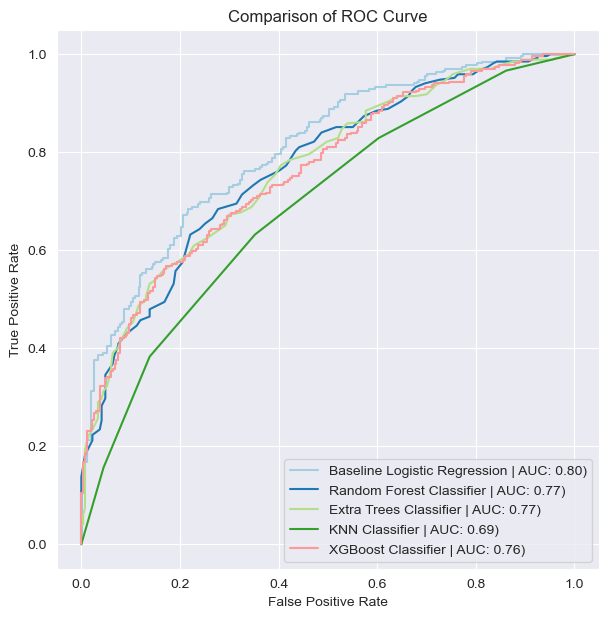

In [35]:
# Looking at ROC Curves to assess overall model performance - Logistic Regression Clearly Looks the Best
xgb.compare_roc_curve()
plt.grid(True)

In [36]:
# Extracting Feature Importances from Tree Models

# rfc_feat = features_from_trees(random_forest)
# etc_feat = features_from_trees(extra_trees)
# xgb_feat = features_from_trees(xgb)

Importance.df

Top 5 Feature Importances
('Team_B_Chalk_Seed', 0.048611539131749704)
('Team_A_Chalk_Seed', 0.04784437208017553)
('Team_B_AvgPtDiff', 0.02396036685922975)
('Team_B_LastTenWinPerc', 0.021204215516993793)
('Team_A_AvgPtDiff', 0.0200971836860925)
Top 5 Feature Importances
('Team_A_Chalk_Seed', 0.05029602002600399)
('Team_B_Chalk_Seed', 0.05004861064496935)
('Team_B_win_perc', 0.013003643182777616)
('Team_B_AvgPtDiff', 0.012769779007106567)
('Team_A_AvgPtDiff', 0.012605509634202964)
Top 5 Feature Importances
('Team_B_Chalk_Seed', 0.049532652)
('Team_A_Chalk_Seed', 0.034928944)
('Team_B_MedPtDiff', 0.026930457)
('Team_B_win_perc', 0.02019445)
('Team_B_Win_Total', 0.016553346)


,Team_A_Avg3ptAtt,Team_A_Avg3ptMade,Team_A_AvgFGAtt,Team_A_AvgFGMade,Team_A_AvgOppScore,Team_A_AvgPtDiff,Team_A_AvgTeamScore,Team_A_Avg_Assts,Team_A_Avg_Blocks,Team_A_Avg_Def_Rebs,Team_A_Avg_FT_Att,Team_A_Avg_FT_Made,Team_A_Avg_Fouls,Team_A_Avg_Off_Rebs,Team_A_Avg_Steals,Team_A_Avg_TO,Team_A_Chalk_Seed,Team_A_CloseGames,Team_A_CloseWins,Team_A_HomeLoss,Team_A_HomeWins,Team_A_LastFivePtDiff,Team_A_LastFiveWinPerc,Team_A_LastTenPtDiff,Team_A_LastTenWinPerc,Team_A_Loss_Total,Team_A_MaxLStreak,Team_A_MaxWStreak,Team_A_MedPtDiff,Team_A_NeutralLoss,Team_A_NeutralWins,Team_A_OTLoss,Team_A_OTWins,Team_A_OppAvg3ptAtt,Team_A_OppAvg3ptMade,Team_A_OppAvgFGAtt,Team_A_OppAvgFGMade,Team_A_OppAvg_Assts,Team_A_OppAvg_Blocks,Team_A_OppAvg_Def_Rebs,Team_A_OppAvg_FT_Att,Team_A_OppAvg_FT_Made,Team_A_OppAvg_Fouls,Team_A_OppAvg_Off_Rebs,Team_A_OppAvg_Steals,Team_A_OppAvg_TO,Team_A_OppTotal3ptAtt,Team_A_OppTotal3ptMade,Team_A_OppTotalFGAtt,Team_A_OppTotalFGMade,Team_A_OppTotal_Assts,Team_A_OppTotal_Def_Rebs,Team_A_OppTotal_FT_Att,Team_A_OppTotal_FT_Made,Team_A_OppTotal_Off_Rebs,Team_A_OppTotal_TO,Team_A_RoadLoss,Team_A_RoadWins,Team_A_StdDevOppScore,Team_A_StdDevTeamScore,Team_A_StdPtDiff,Team_A_Win_Total,Team_A_close_game_win_perc,Team_A_home_win_perc,Team_A_neutral_win_perc,Team_A_ot_win_perc,Team_A_road_win_perc,Team_A_win_perc,Team_B_Avg3ptAtt,Team_B_Avg3ptMade,Team_B_AvgFGAtt,Team_B_AvgFGMade,Team_B_AvgOppScore,Team_B_AvgPtDiff,Team_B_AvgTeamScore,Team_B_Avg_Assts,Team_B_Avg_Blocks,Team_B_Avg_Def_Rebs,Team_B_Avg_FT_Att,Team_B_Avg_FT_Made,Team_B_Avg_Fouls,Team_B_Avg_Off_Rebs,Team_B_Avg_Steals,Team_B_Avg_TO,Team_B_Chalk_Seed,Team_B_CloseGames,Team_B_CloseWins,Team_B_HomeLoss,Team_B_HomeWins,Team_B_LastFivePtDiff,Team_B_LastFiveWinPerc,Team_B_LastTenPtDiff,Team_B_LastTenWinPerc,Team_B_Loss_Total,Team_B_MaxLStreak,Team_B_MaxWStreak,Team_B_MedPtDiff,Team_B_NeutralLoss,Team_B_NeutralWins,Team_B_OTLoss,Team_B_OTWins,Team_B_OppAvg3ptAtt,Team_B_OppAvg3ptMade,Team_B_OppAvgFGAtt,Team_B_OppAvgFGMade,Team_B_OppAvg_Assts,Team_B_OppAvg_Blocks,Team_B_OppAvg_Def_Rebs,Team_B_OppAvg_FT_Att,Team_B_OppAvg_FT_Made,Team_B_OppAvg_Fouls,Team_B_OppAvg_Off_Rebs,Team_B_OppAvg_Steals,Team_B_OppAvg_TO,Team_B_OppTotal3ptAtt,Team_B_OppTotal3ptMade,Team_B_OppTotalFGAtt,Team_B_OppTotalFGMade,Team_B_OppTotal_Assts,Team_B_OppTotal_Def_Rebs,Team_B_OppTotal_FT_Att,Team_B_OppTotal_FT_Made,Team_B_OppTotal_Off_Rebs,Team_B_OppTotal_TO,Team_B_RoadLoss,Team_B_RoadWins,Team_B_StdDevOppScore,Team_B_StdDevTeamScore,Team_B_StdPtDiff,Team_B_Win_Total,Team_B_close_game_win_perc,Team_B_home_win_perc,Team_B_neutral_win_perc,Team_B_ot_win_perc,Team_B_road_win_perc,Team_B_win_perc,missingindicator_Team_A_close_game_win_perc,missingindicator_Team_A_home_win_perc,missingindicator_Team_A_neutral_win_perc,missingindicator_Team_A_ot_win_perc,missingindicator_Team_B_close_game_win_perc,missingindicator_Team_B_home_win_perc,missingindicator_Team_B_neutral_win_perc,missingindicator_Team_B_ot_win_perc
Baseline Logistic Regression,0.225952,0.088628,0.223829,0.750206,-0.228961,0.637401,0.640767,0.261619,1.321499,-0.779747,0.132728,0.003858,-0.356515,-0.048486,0.037132,-0.283606,-1.959656,0.109863,-0.080853,0.132631,0.156717,-0.755056,-0.352683,-0.447223,-0.394600,0.131736,-0.011977,0.370245,-0.064396,0.060430,0.189868,-0.218025,-0.064844,0.146813,-0.378717,0.001674,-0.276944,-0.108129,-0.013056,-0.945344,-0.659690,0.215983,-0.482475,-0.407308,-0.227351,0.435784,0.147324,-0.396221,0.427905,0.190190,0.164117,-0.171571,-0.466357,0.309962,0.039398,0.846084,0.074796,0.238170,-0.588126,-0.274784,0.608385,0.405711,-0.710330,0.111432,0.137371,-0.223490,0.573781,-0.161711,0.321314,-0.021214,-0.218538,-0.857510,0.349252,-0.803097,-0.707594,0.382983,-0.204950,-0.105482,1.121852,-0.036896,0.569705,-0.535131,-0.264348,0.294932,2.204178,0.385708,-0.231818,-0.480630,0.013843,-0.152546,-0.352630,0.059082,-0.674713,-0.286340,-0.117243,0.282191,-0.420201,-0.443234,-0.589267,-0.303976,0.299677,0.014839,0.182901,0.569851,0.33358

In [96]:
# This function displays dataframes of the largest 20 magnitude coefs/feature importances

for i in [logreg_coef, rfc_feat, etc_feat, xgb_feat]:
    print(get_largest_magnitudes(20, i), "\n")

                                Feature Name  Coef/Importance
0                          Team_B_Chalk_Seed         2.204178
1                          Team_A_Chalk_Seed        -1.959656
2                          Team_A_Avg_Blocks         1.321499
3                          Team_B_Avg_FT_Att         1.121852
4                     Team_A_OppAvg_Def_Rebs        -0.945344
5   missingindicator_Team_A_neutral_win_perc        -0.903484
6                           Team_B_AvgFGMade        -0.857510
7                         Team_A_OppTotal_TO         0.846084
8                           Team_B_AvgPtDiff        -0.803097
9                        Team_A_Avg_Def_Rebs        -0.779747
10                     Team_A_LastFivePtDiff        -0.755056
11                          Team_A_AvgFGMade         0.750206
12                    Team_B_OppAvg_Def_Rebs         0.743420
13                Team_A_close_game_win_perc        -0.710330
14                       Team_B_AvgTeamScore        -0.707594
15      

In [37]:
# XGB by itself

get_largest_magnitudes(20, xgb_feat)

,Feature Name,Coef/Importance
0,Team_B_Chalk_Seed,0.049533
1,Team_A_Chalk_Seed,0.034929
2,Team_B_MedPtDiff,0.026930
3,Team_B_win_perc,0.020194
4,Team_B_Win_Total,0.016553
5,Team_A_RoadLoss,0.015946
6,Team_B_road_win_perc,0.015227
7,Team_B_AvgPtDiff,0.015120
8,Team_A_AvgPtDiff,0.013530
9,Team_A_win_perc,0.013281


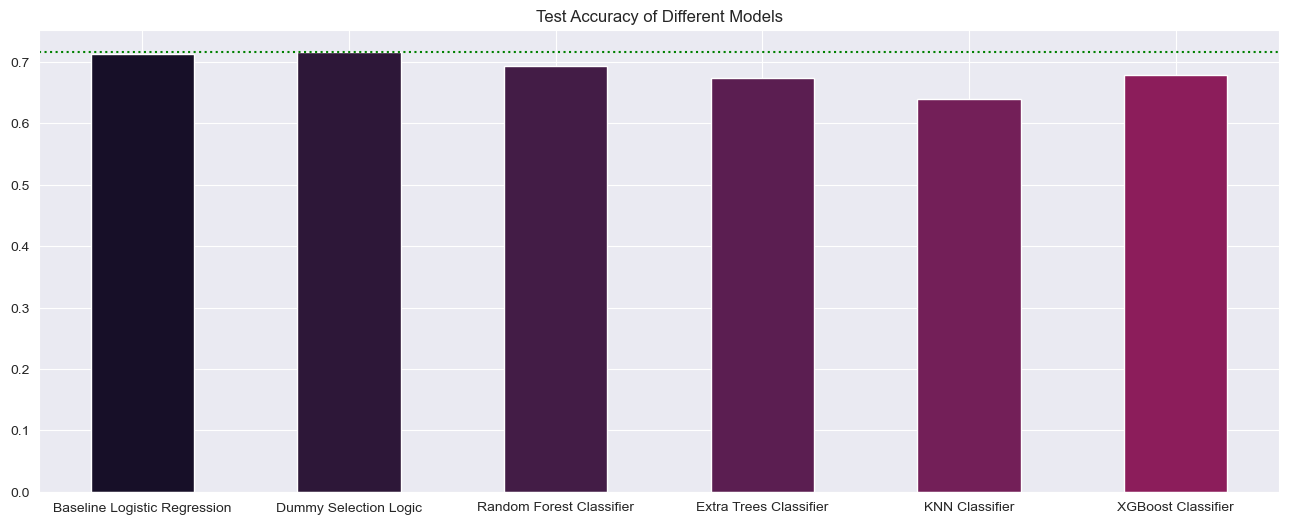

In [44]:
# Plotting Test Accuracy
fig, ax = plt.subplots(figsize = (16, 6))
pal = sns.color_palette("rocket", n_colors=16)
Model.model_df["test_accuracy"].plot(kind="bar", title="Test Accuracy of Different Models", color=pal)
ax.set_xticklabels(Model.model_df["name"], rotation = 0)
ax.axhline(Model.model_df.query("name == 'Dummy Selection Logic'")["test_accuracy"].values, \
           linestyle = ":", color="green")
plt.grid(True);

### Observations For These Models:
Again, I am consistently observing that the models use the respective Chalk Seeds as the most important feature. For the tree models, `Seeds are 3x more important` than the next feature on average. Also, XGBoost did not use the recent 10/5 game trends as a feature of importance, which is different than the other tree models. Given that none of these models have performed better than the dummy logic. I will have to attempt to adjust the features and target values in hopes of achieving better results. 

In [45]:
for i in range(3, 16, 2):
    pipe_model = Pipeline(steps=[
    ("ct", ct),
    ('model', KNeighborsClassifier(n_neighbors=i))
])
    
    
    pipe_model.fit(X_train, y_train)
    filler = Model(f"KNN| N={i}", pipe_model, X_train, X_test, y_train, y_test)
    
Model.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
1,Dummy Selection Logic,0.734745,0.739021,0.729864,0.734414,9.560770,0.716418,0.705263,0.747212,0.725632,10.221335,NaN
0,Baseline Logistic Regression,0.726635,0.728829,0.729829,0.728665,0.530540,0.712687,0.694915,0.762082,0.726950,0.536016,0.804617
2,Random Forest Classifier,0.717920,0.730259,0.703803,0.715201,0.553626,0.694030,0.688172,0.713755,0.700730,0.571604,0.768354
5,XGBoost Classifier,0.715425,0.728680,0.695100,0.710133,0.702211,0.679104,0.673835,0.698885,0.686131,0.837950,0.760787
3,Extra Trees Classifier,0.717298,0.718752,0.721164,0.719473,0.553472,0.673507,0.664336,0.706320,0.684685,0.577592,0.765340
12,KNN| N=15,0.674333,0.684372,0.659213,0.669854,0.587776,0.669776,0.669118,0.676580,0.672828,0.649895,0.746592
10,KNN| N=11,0.676212,0.686002,0.659236,0.671238,0.636025,0.667910,0.669145,0.669145,0.669145,0.786707,0.735976
11,KNN| N=13,0.664993,0.672758,0.653033,0.661788,0.616326,0.666045,0.667910,0.665428,0.666667,0.654479,0.739986
9,KNN| N=9,0.674331,0.682854,0.657986,0.669700,0.741999,0.660448,0.652632,0.691450,0.671480,0.856465,0.726835
4,KNN Classifier,0.657528,0.660910,0.656759,0.658195,1.388824,0.639925,0.643939,0.631970,0.637899,1.968196,0.688644


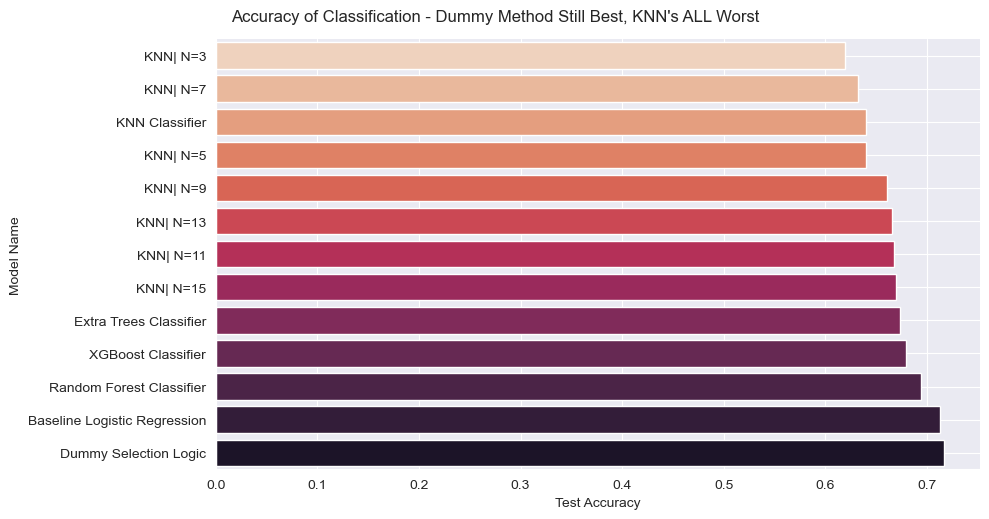

In [46]:
# Displaying the accuracies of different models so far

g = sns.catplot(data=Model.model_df.sort_values("test_accuracy"), x="test_accuracy", y='name', kind="bar", aspect=2,\
               palette="rocket_r")
g.fig.suptitle("Accuracy of Classification - Dummy Method Still Best, KNN's ALL Worst", y=1.03,)
g.set(xlabel="Test Accuracy", ylabel="Model Name")
plt.grid(True);

<hr style="border: 2px solid blue">

<div class= "alert alert-block alert-info" style = "font-size: 2em;">
<b>New Features:</b> Differences between Team_A and Team_B Statistics
</div>

Instead of using the single-team aggregated statistics, I will now consolidate the features from each respective team into a single column reflecting the difference between the two teams statistics. The only columns that will be exceptions are the categorical columns, such as conference or trend categories. I will perform the same train-test split on this new data with the same target value "y", and see if model performance improves at all. The predictions from dummy logic will remain the same, so comparisons will be made to previous models. 

In [47]:
# Create a new dataframe for the differenced data
diff_df = pd.DataFrame()

# Iterate through X to see if the column name starts with "Team_A" 
for i in X.select_dtypes(exclude="category").columns:
    if i[:7] == "Team_A_":
        # Capture the general statistic
        feature = i[7:]
        
        # Create new column in new 'X-like' dataframe
        diff_df[f"{feature}_diff"] = X[f"Team_A_{feature}"] - X[f"Team_B_{feature}"]
    
    
# Add the categorical features back to the data
diff_df = pd.concat([diff_df, X.select_dtypes(include="category")], axis=1)

In [48]:
# By consolidating columns, I reduced the features nearly by half

diff_df.shape, X.shape

((2142, 77), (2142, 145))

In [49]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(diff_df, y, random_state=13, test_size=.25, \
                                                    shuffle=True, stratify=y)

In [58]:
# Fitting a Logistic Regression Model to the Differenced Data

pipe_model = Pipeline(steps=[
    ("ct", ct),
    ('model', RandomForestClassifier(random_state=13))
])

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867db10>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867d7e0>)])),
                ('model', RandomForestClassifier(random_state=13))])

In [61]:
# diff_logreg = Model("LogReg - Diff Data", pipe_model, X_train, X_test, y_train, y_test)

# diff_rfc = Model("RFC - Diff Data", pipe_model, X_train, X_test, y_train, y_test)

# diff_rfc_redo = Model("RFC - Diff Data State-13", pipe_model, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.0s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
15,RFC - Diff Data State-13,0.720400,0.721189,0.726087,0.723122,0.548799,0.729478,0.718310,0.758364,0.737794,0.561726,0.783823
13,RFC - Diff Data,0.719779,0.719309,0.729806,0.723886,0.545105,0.723881,0.709343,0.762082,0.734767,0.559160,0.788028
1,Dummy Selection Logic,0.734745,0.739021,0.729864,0.734414,9.560770,0.716418,0.705263,0.747212,0.725632,10.221335,NaN
0,Baseline Logistic Regression,0.726635,0.728829,0.729829,0.728665,0.530540,0.712687,0.694915,0.762082,0.726950,0.536016,0.804617
14,LogReg - Diff Data,0.732859,0.731165,0.744690,0.737223,0.520316,0.705224,0.700361,0.721190,0.710623,0.528553,0.807123
2,Random Forest Classifier,0.717920,0.730259,0.703803,0.715201,0.553626,0.694030,0.688172,0.713755,0.700730,0.571604,0.768354
5,XGBoost Classifier,0.715425,0.728680,0.695100,0.710133,0.702211,0.679104,0.673835,0.698885,0.686131,0.837950,0.760787
3,Extra Trees Classifier,0.717298,0.718752,0.721164,0.719473,0.553472,0.673507,0.664336,0.706320,0.684685,0.577592,0.765340
12,KNN| N=15,0.674333,0.684372,0.659213,0.669854,0.587776,0.669776,0.669118,0.676580,0.672828,0.649895,0.746592
10,KNN| N=11,0.676212,0.686002,0.659236,0.671238,0.636025,0.667910,0.669145,0.669145,0.669145,0.786707,0.735976


In [65]:
def compare_curves(list_of_models):
    """
    Function to compare the ROC curves of selected model objects
    
    Parameters
    -----------------
    list_of_models: list| this list contains instances of the custom Model class
    
    
    Returns
    -----------------
    figure: matplotlib.pyplot figure| plot of ROC curves for len(list_of_models) models
        useful for visual comparison of model performance.  
    """
    sns.set_style("dark")
    # Color Palette
    colors = sns.color_palette("Paired", n_colors=8)
    # Create the plot
    fig, ax = plt.subplots(figsize=(7,7))
    for i in range(len(list_of_models)):
        # get the predict_proba values
        y_hat_hd = list_of_models[i].y_pred_proba[:, 1]

        # Get the FPR and TPR data
        fpr, tpr, thresholds = roc_curve(list_of_models[i].y_test, y_hat_hd)
        # Plot the actual graph
        ax.plot(fpr, tpr, color=colors[i], label=f'{list_of_models[i].name} | AUC: {list_of_models[i].auc:.2f})')

    ax.set_title(f"Comparison of ROC Curves")
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
    plt.grid(False);

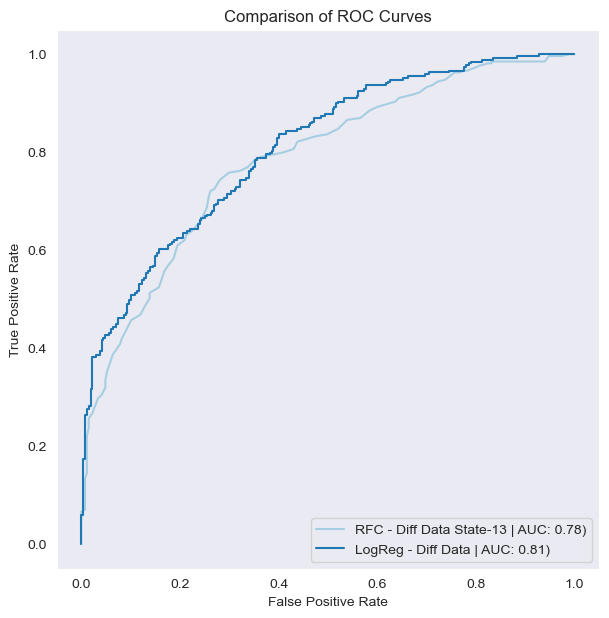

In [66]:
# Inspecting the ROC curves 
compare_curves([diff_rfc_redo, diff_logreg])

In [67]:
# Extract and inspect feature importances for the RFC random_state = 13 model with best performance so far
rfc_diff_list = features_from_trees(diff_rfc_redo, 10)

Top 10 Feature Importances
('Chalk_Seed_diff', 0.09686641906604881)
('AvgPtDiff_diff', 0.04638006513842501)
('LastFiveWinPerc_diff', 0.03207837405197578)
('LastTenWinPerc_diff', 0.031036518349105018)
('AvgFGMade_diff', 0.025242721825484104)
('win_perc_diff', 0.022104271199106157)
('HomeWins_diff', 0.020505542807865845)
('Avg_Blocks_diff', 0.01997031002032818)
('MedPtDiff_diff', 0.019265140531899913)
('AvgTeamScore_diff', 0.01914493343683827)


In [70]:
# Extract and inspect logistic regression coefficients for comparison

logreg_diff_list = coefs_from_lr(diff_logreg, 10)

Top 10 Feature Coefficients by Absolute Value
('Chalk_Seed_diff', -3.7485898076813458)
('OppAvg_Def_Rebs_diff', -1.2750655908797575)
('Avg_Blocks_diff', 1.1714339107205651)
('AvgTeamScore_diff', 1.0539489407763196)
('AvgFGMade_diff', 1.0143428477199528)
('AvgPtDiff_diff', 0.9631471448780374)
('OppTotal_TO_diff', 0.870984145231033)
('OppAvg_Fouls_diff', -0.7678017587533323)
('NeutralWins_diff', 0.7324570420420806)
('Avg_Fouls_diff', -0.710803754870469)


In [83]:
logreg_diff_list[10:20]

[('NeutralLoss_diff', 0.6128455732702062),
 ('OppAvg_Off_Rebs_diff', -0.5802420931715162),
 ('OppAvg_Steals_diff', -0.5291716911871941),
 ('OppAvg_Assts_diff', -0.5128345958457218),
 ('OTWins_diff', -0.503838835878888),
 ('OppAvg_FT_Att_diff', -0.49727704707031684),
 ('Avg_TO_diff', -0.4903822196211551),
 ('close_game_win_perc_diff', -0.4786756153445456),
 ('LastTenPtDiff_diff', -0.4781763579852247),
 ('Avg_FT_Att_diff', -0.45794483869992925)]

In [82]:
rfc_diff_list[10:20]

[('StdPtDiff_diff', 0.019007059357597045),
 ('OppAvg_Def_Rebs_diff', 0.018280334787884805),
 ('Win_Total_diff', 0.017215362710434376),
 ('AvgFGAtt_diff', 0.016576493842568915),
 ('LastFivePtDiff_diff', 0.014778810279153164),
 ('Avg_Assts_diff', 0.014393065308145072),
 ('Avg_Fouls_diff', 0.014364302306526975),
 ('StdDevTeamScore_diff', 0.014227503137472246),
 ('LastTenPtDiff_diff', 0.01368164917303874),
 ('OppAvgFGMade_diff', 0.013577965799931662)]

In [90]:
# Comparing features 11-20 ... no aggreement here except for 'LastTenPtDiff_diff'
[(rfc_diff_list[i][0], logreg_diff_list[i][0]) for i in range(10, 21)]

[('StdPtDiff_diff', 'NeutralLoss_diff'),
 ('OppAvg_Def_Rebs_diff', 'OppAvg_Off_Rebs_diff'),
 ('Win_Total_diff', 'OppAvg_Steals_diff'),
 ('AvgFGAtt_diff', 'OppAvg_Assts_diff'),
 ('LastFivePtDiff_diff', 'OTWins_diff'),
 ('Avg_Assts_diff', 'OppAvg_FT_Att_diff'),
 ('Avg_Fouls_diff', 'Avg_TO_diff'),
 ('StdDevTeamScore_diff', 'close_game_win_perc_diff'),
 ('LastTenPtDiff_diff', 'LastTenPtDiff_diff'),
 ('OppAvgFGMade_diff', 'Avg_FT_Att_diff'),
 ('OppTotal_Def_Rebs_diff', 'Avg_Off_Rebs_diff')]

### Comparison of the models trained on differenced features:
Chalk seed remains the number 1 feature for both Logistic Regression and Random Forest models. **`AvgPtDiff_diff`** also appears in the top ten of both (6 for logreg, 2 for RFC), **`Avg_Blocks_Diff`** (2 for logreg, 8 for RFC), **`AVG_Team_Score_diff`** (4 for logreg, 10 for RFC), and **`AvgFGMade_diff`** (5 for both). The only feature in common for magnitudes 11-20 is **`LastTenPtDiff_diff`**. I will try to use these features as a basis for the next phase in my modeling.

<div class="alert alert-info alert-block"; style="font-size: 2em";>
    <b> Incorporating Features from the Ground Up: </b> Adding Efficiency Stats
</div>

### Learning from Previous Iterations
The features used in my dummy logic continue to be prominently ranked as features in my models. I would like to strip down the feature space, and build out the features I used based on the importances I have observed from these first models. I will use the following features which were found in the top-20 for LR and RFC models. I will observe and assess how the models respond to these limited features:

- ChalkSeed_diff
- AvgPtDiff_diff
- Avg_Blocks_Diff
- AVG_Team_Score_diff
- AvgFGMade_diff
- LastTenPtDiff_diff

I will also choose to include **`'win_perc_diff'`**, **`'Team_A_Conference'`**, and **`'Team_B_Conference'`** because win % is also the basis of our dummy logic, and conferences are the only categorical value not captured in the continuous statistics. 

<hr style="border: 2px solid blue">

### Efficiency Metrics

I also want to include **offensive_eff** and **defensive_eff** statistics. Offensive efficiency is calculated by first determining the number of possessions a team has, and dividing the points scored by that figure. Possessions are calculated by adding FG attempts, Turnovers, and 0.4 * FT attempts, and subtracting Offensive Rebounds:

##### - *Possessions* = Field goal attempts - Offensive rebounds + Turnovers + (0.4 * Free throw attempts)

Then you calculate efficiency by performing:

##### - *Offensive Efficiency* = (Points Scored / Possessions) * 100 

*`Defensive efficiency`* is essentially the same calculation. You find the opponents number of possessions using the same methodology, and then divide opponents score by that. 

##### - *Defensive Efficiency* = (Opponents' Points Scored / Opponents' Possessions) * 100

In [103]:
def calculate_efficiency(data):
    """
    Function to calculate both Teams' offensive and defensive efficiency scores
    
    Parameters:
    ----------------
    data: pandas.DataFrame | a dataframe with aggregated statistics from a team's season
    
    Returns:
    ----------------
    Team A Offensive and Defensive Efficiency scores, Team_B Offensive and Defensive Efficiency scores
    """
    
        
    # Team A Offense
    team_a_off_poss = data["Team_A_AvgFGAtt"] + data["Team_A_Avg_TO"] + data['Team_A_Avg_FT_Att']\
                    - data["Team_A_Avg_Off_Rebs"]

    team_a_off_eff =  data["Team_A_AvgTeamScore"] / team_a_off_poss
    
    # Team A Defense
    team_a_def_poss = data["Team_A_OppAvgFGAtt"] + data["Team_A_OppAvg_TO"] + data['Team_A_OppAvg_FT_Att']\
                    - data["Team_A_OppAvg_Off_Rebs"]

    team_a_def_eff =  data["Team_A_AvgOppScore"] / team_a_def_poss



    # Team B Offense
    team_b_off_poss = data["Team_B_AvgFGAtt"] + data["Team_B_Avg_TO"] + data['Team_B_Avg_FT_Att']\
                    - data["Team_B_Avg_Off_Rebs"]

    team_b_off_eff =  data["Team_B_AvgTeamScore"] / team_b_off_poss
    
    # Team B Defense
    
    team_b_def_poss = data["Team_B_OppAvgFGAtt"] + data["Team_B_OppAvg_TO"] + data['Team_B_OppAvg_FT_Att']\
                    - data["Team_B_OppAvg_Off_Rebs"]

    team_b_def_eff =  data["Team_B_AvgOppScore"] / team_b_def_poss
    
    return team_a_off_eff, team_a_def_eff, team_b_off_eff, team_b_def_eff

### New df for modeling:

In [137]:
# Need to use the "dropped" df object as it has the individual team data rather than differences

eff_df = pd.DataFrame()
eff_df["team_a_off_eff"], eff_df['team_a_def_eff'], eff_df["team_b_off_eff"], eff_df['team_b_def_eff'] \
= calculate_efficiency(dropped)
eff_df

,team_a_off_eff,team_a_def_eff,team_b_off_eff,team_b_def_eff
1136,0.852459,0.868765,0.872044,0.949499
1137,0.943456,0.815506,0.885985,0.850441
1138,0.910707,0.857265,0.901920,0.809584
1139,0.990906,0.824466,0.927823,0.874794
1140,0.925043,0.866978,0.917587,0.871983
...,...,...,...,...
4029,0.968053,0.639922,0.908720,0.814956
4030,0.927775,0.748942,0.915987,0.792453
4031,0.968053,0.639922,0.984880,0.819160
4032,0.946717,0.691693,0.927775,0.748942


In [138]:
selected_data.shape

(2142, 8)

In [139]:
# Choosing the features from the differenced data

selected_data = diff_df[["Chalk_Seed_diff", "AvgPtDiff_diff", "Avg_Blocks_diff", \
                         "AvgTeamScore_diff", "AvgFGMade_diff", "LastTenPtDiff_diff", "Team_A_Conference",\
                         "Team_B_Conference"]].copy()

# Combining selected features and efficiency metrics
eff_df = pd.concat([eff_df, selected_data], axis=1)

# Inspection - 2142 rows, and 12 features only now
print(eff_df.shape)
eff_df.head()

(2142, 12)


,team_a_off_eff,team_a_def_eff,team_b_off_eff,team_b_def_eff,Chalk_Seed_diff,AvgPtDiff_diff,Avg_Blocks_diff,AvgTeamScore_diff,AvgFGMade_diff,LastTenPtDiff_diff,Team_A_Conference,Team_B_Conference
1136,0.852459,0.868765,0.872044,0.949499,0.0,9.208046,-0.766667,1.593103,0.354023,0.3,swac,big_south
1137,0.943456,0.815506,0.885985,0.850441,-15.0,10.309113,1.248768,17.421182,5.493842,5.3,pac_ten,aec
1138,0.910707,0.857265,0.901920,0.809584,3.0,-1.896552,-0.827586,1.448276,0.931034,-4.6,pac_ten,cusa
1139,0.990906,0.824466,0.927823,0.874794,-5.0,8.805643,0.454545,-0.102403,2.076280,-4.7,mvc,mac
1140,0.925043,0.866978,0.917587,0.871983,1.0,-0.324138,0.273563,-2.082759,-3.011494,-3.3,acc,pac_ten


<hr style="border: 2px solid blue">
<div class= "alert alert-info alert block;" style="font-size: 2em";>
    <b>Stripped Down Features Space:</b> Ready for More Models
</div>

I'll perform another train-test split using this data and see how the new models perform.

In [143]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(eff_df, y, random_state=13, test_size=.25, \
                                                    shuffle=True, stratify=y)

In [146]:
# Fitting a RandomForestClassifier

pipe_model = Pipeline(steps=[
    ("ct", ct),
    ('model', RandomForestClassifier(random_state=13))
])

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867db10>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867d7e0>)])),
                ('model', RandomForestClassifier(random_state=13))])

In [147]:
# Stripped Down Features Models Instantiation

# LR
# logreg_stripped = Model("LR - Stripped", pipe_model, X_train, X_test, y_train, y_test)

# RFC
# rfc_stripped = Model("RFC - Stripped", pipe_model, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.1s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
15,RFC - Diff Data State-13,0.720400,0.721189,0.726087,0.723122,0.548799,0.729478,0.718310,0.758364,0.737794,0.561726,0.783823
13,RFC - Diff Data,0.719779,0.719309,0.729806,0.723886,0.545105,0.723881,0.709343,0.762082,0.734767,0.559160,0.788028
1,Dummy Selection Logic,0.734745,0.739021,0.729864,0.734414,9.560770,0.716418,0.705263,0.747212,0.725632,10.221335,NaN
16,LR - Stripped,0.738465,0.734507,0.755862,0.744232,0.514059,0.714552,0.701389,0.750929,0.725314,0.532195,0.803322
0,Baseline Logistic Regression,0.726635,0.728829,0.729829,0.728665,0.530540,0.712687,0.694915,0.762082,0.726950,0.536016,0.804617
14,LogReg - Diff Data,0.732859,0.731165,0.744690,0.737223,0.520316,0.705224,0.700361,0.721190,0.710623,0.528553,0.807123
17,RFC - Stripped,0.729748,0.728910,0.739752,0.732968,0.536741,0.695896,0.676667,0.754647,0.713533,0.546866,0.792441
2,Random Forest Classifier,0.717920,0.730259,0.703803,0.715201,0.553626,0.694030,0.688172,0.713755,0.700730,0.571604,0.768354
5,XGBoost Classifier,0.715425,0.728680,0.695100,0.710133,0.702211,0.679104,0.673835,0.698885,0.686131,0.837950,0.760787
3,Extra Trees Classifier,0.717298,0.718752,0.721164,0.719473,0.553472,0.673507,0.664336,0.706320,0.684685,0.577592,0.765340


In [148]:
# Extracting features and coefficients

lr_stripped_list = coefs_from_lr(logreg_stripped)
rfc_stripped_list = features_from_trees(rfc_stripped)

Top 5 Feature Coefficients by Absolute Value
('Chalk_Seed_diff', -4.170225004268089)
('AvgPtDiff_diff', 1.9761376593341642)
('team_b_off_eff', -1.9028430621569672)
('team_a_off_eff', 1.1179092701501008)
('team_b_def_eff', 1.0916143764243544)
Top 5 Feature Importances
('Chalk_Seed_diff', 0.22068063104533212)
('AvgPtDiff_diff', 0.14426859646678725)
('AvgFGMade_diff', 0.09814269629862099)
('Avg_Blocks_diff', 0.09033287562134122)
('AvgTeamScore_diff', 0.08336769719462932)


In [149]:
lr_stripped_list

[('Chalk_Seed_diff', -4.170225004268089),
 ('AvgPtDiff_diff', 1.9761376593341642),
 ('team_b_off_eff', -1.9028430621569672),
 ('team_a_off_eff', 1.1179092701501008),
 ('team_b_def_eff', 1.0916143764243544),
 ('AvgFGMade_diff', 1.0868080283840496),
 ('Avg_Blocks_diff', 0.8702892760255585),
 ('team_a_def_eff', -0.700789989631133),
 ('AvgTeamScore_diff', -0.5858653391797248),
 ('LastTenPtDiff_diff', -0.5403692869455571)]

In [150]:
rfc_stripped_list

[('Chalk_Seed_diff', 0.22068063104533212),
 ('AvgPtDiff_diff', 0.14426859646678725),
 ('AvgFGMade_diff', 0.09814269629862099),
 ('Avg_Blocks_diff', 0.09033287562134122),
 ('AvgTeamScore_diff', 0.08336769719462932),
 ('team_b_off_eff', 0.07801323083759439),
 ('LastTenPtDiff_diff', 0.07287504900697099),
 ('team_b_def_eff', 0.0717149240283897),
 ('team_a_def_eff', 0.07079797956229893),
 ('team_a_off_eff', 0.06980631993803518)]

### RFC did much worse than its previous score with differenced data....
I will see if adding the efficiency data to the differenced data will provide better results.

In [152]:
# Need to use the "dropped" df object as it has the individual team data rather than differences

efficiency = pd.DataFrame()

# Using the calculate_efficiency function to generate efficiency statistics
efficiency["Team_A_Off_Eff"], efficiency['Team_A_Def_Eff'], efficiency["Team_B_Off_Eff"], efficiency['Team_B_Def_Eff'] \
= calculate_efficiency(dropped)

# Inspection
efficiency

,team_a_off_eff,team_a_def_eff,team_b_off_eff,team_b_def_eff
1136,0.852459,0.868765,0.872044,0.949499
1137,0.943456,0.815506,0.885985,0.850441
1138,0.910707,0.857265,0.901920,0.809584
1139,0.990906,0.824466,0.927823,0.874794
1140,0.925043,0.866978,0.917587,0.871983
...,...,...,...,...
4029,0.968053,0.639922,0.908720,0.814956
4030,0.927775,0.748942,0.915987,0.792453
4031,0.968053,0.639922,0.984880,0.819160
4032,0.946717,0.691693,0.927775,0.748942


### Creating new df: trial

In [154]:
# Concatenating differences between teams with the new efficiency statistics
trial = pd.concat([diff_df, efficiency], axis=1)

# Inspecting the new df
print(trial.shape)
trial.head()

(2142, 81)


,Avg3ptAtt_diff,Avg3ptMade_diff,AvgFGAtt_diff,AvgFGMade_diff,AvgOppScore_diff,AvgPtDiff_diff,AvgTeamScore_diff,Avg_Assts_diff,Avg_Blocks_diff,Avg_Def_Rebs_diff,Avg_FT_Att_diff,Avg_FT_Made_diff,Avg_Fouls_diff,Avg_Off_Rebs_diff,Avg_Steals_diff,Avg_TO_diff,Chalk_Seed_diff,CloseGames_diff,CloseWins_diff,HomeLoss_diff,HomeWins_diff,LastFivePtDiff_diff,LastFiveWinPerc_diff,LastTenPtDiff_diff,LastTenWinPerc_diff,Loss_Total_diff,MaxLStreak_diff,MaxWStreak_diff,MedPtDiff_diff,NeutralLoss_diff,NeutralWins_diff,OTLoss_diff,OTWins_diff,OppAvg3ptAtt_diff,OppAvg3ptMade_diff,OppAvgFGAtt_diff,OppAvgFGMade_diff,OppAvg_Assts_diff,OppAvg_Blocks_diff,OppAvg_Def_Rebs_diff,OppAvg_FT_Att_diff,OppAvg_FT_Made_diff,OppAvg_Fouls_diff,OppAvg_Off_Rebs_diff,OppAvg_Steals_diff,OppAvg_TO_diff,OppTotal3ptAtt_diff,OppTotal3ptMade_diff,OppTotalFGAtt_diff,OppTotalFGMade_diff,OppTotal_Assts_diff,OppTotal_Def_Rebs_diff,OppTotal_FT_Att_diff,OppTotal_FT_Made_diff,OppTotal_Off_Rebs_diff,OppTotal_TO_diff,RoadLoss_diff,RoadWins_diff,StdDevOppScore_diff,StdDevTeamScore_diff,StdPtDiff_diff,Win_Total_diff,close_game_win_perc_diff,home_win_perc_diff,neutral_win_perc_diff,ot_win_perc_diff,road_win_perc_diff,win_perc_diff,League,Team_A_Conference,Team_A_Loc,Team_A_Relative_Diff_Trend,Team_A_Relative_Win_Trend,Team_B_Conference,Team_B_Loc,Team_B_Relative_Diff_Trend,Team_B_Relative_Win_Trend,team_a_off_eff,team_a_def_eff,team_b_off_eff,team_b_def_eff
1136,0.500000,-0.549425,-1.526437,0.354023,-7.614943,9.208046,1.593103,1.165517,-0.766667,1.627586,7.135632,1.434483,-0.803448,0.890805,-0.635632,-0.973563,0.0,4.0,2.0,1.0,1.0,7.6,0.156556,0.3,0.143506,-4.0,2.0,3.0,5.5,1.0,2.0,0.0,-3.0,2.408046,-0.087356,-0.565517,-2.126437,-2.095402,-1.641379,0.039080,-3.818391,-3.274713,2.943678,-1.790805,-0.827586,1.505747,93.0,5.0,44.0,-36.0,-47.0,24.0,-92.0,-83.0,-40.0,58.0,-6.0,2.0,-0.704848,0.465604,-5.304795,5.0,-0.057143,-0.047619,-0.25,0.000000,0.208333,0.151724,Men,swac,N,Trending Up,On Trend,big_south,N,On Trend,On Trend,0.852459,0.868765,0.872044,0.949499
1137,4.588670,1.759852,9.852217,5.493842,7.112069,10.309113,17.421182,3.435961,1.248768,1.918719,5.448276,4.673645,1.853448,2.213054,1.602217,0.716749,-15.0,-2.0,0.0,0.0,5.0,-2.6,0.287097,5.3,0.291346,-7.0,-4.0,6.0,7.0,-1.0,-3.0,0.0,1.0,-1.483990,-0.747537,9.609606,3.598522,2.188424,-1.262315,1.423645,1.955665,0.662562,4.140394,3.520936,-1.139163,3.857143,-63.0,-28.0,214.0,78.0,48.0,18.0,39.0,8.0,89.0,95.0,-6.0,4.0,-1.024895,-1.615862,-0.045316,6.0,0.171429,0.033333,-0.60,0.500000,0.416667,0.237685,Men,pac_ten,N,Trending Down,On Trend,aec,N,On Trend,On Trend,0.943456,0.815506,0.885985,0.850441
1138,-7.482759,-3.000000,-3.103448,0.931034,3.344828,-1.896552,1.448276,-1.068966,-0.827586,-2.655172,3.310345,2.586207,0.655172,-0.379310,-2.172414,0.206897,3.0,0.0,0.0,1.0,-2.0,-8.8,-0.177696,-4.6,-0.138658,5.0,1.0,-7.0,-2.0,2.0,0.0,-1.0,2.0,-2.413793,-0.448276,-2.206897,1.517241,0.758621,0.758621,-3.034483,-0.206897,0.758621,2.931034,-1.344828,-1.275862,0.448276,-70.0,-13.0,-64.0,44.0,22.0,-88.0,-6.0,22.0,-39.0,13.0,2.0,-3.0,1.356380,3.244223,6.224259,-5.0,0.000000,-0.075000,-0.50,1.000000,-0.236364,-0.172414,Men,pac_ten,N,Trending Down,Trending Down,cusa,N,On Trend,On Trend,0.910707,0.857265,0.901920,0.809584
1139,2.553814,1.142111,4.764890,2.076280,-8.908046,8.805643,-0.102403,1.197492,0.454545,-0.094044,-5.142111,-5.397074,-3.692790,0.292581,1.290491,-4.877743,-5.0,-3.0,-2.0,-1.0,6.0,-8.2,0.093533,-4.7,0.115693,-2.0,-1.0,4.0,6.0,0.0,2.0,0.0,1.0,0.406479,-0.086729,-2.597701,-2.466040,0.570533,0.092999,2.467085,-5.268548,-3.889237,-2.295716,-1.180773,-2.114943,0.991641,69.0,17.0,146.0,24.0,66.0,157.0,-86.0,-66.0,10.0,97.0,-1.0,-2.0,-0.132381,-0.839180,1.741362,6.0,0.057143,0.083333,0.00,NaN,-0.006494,0.085684,Men,mvc,N,On Trend,On Trend,mac,N,Trending Up,On Trend,0.990906,0.824466,0.927823,0.874794
1140,5.465517,1.552874,-5.390805,-3.011494,-1.758621,-0.324138,-2.082759,-1.333333,0.273563,-2.345977,0.949425,2.387356,1.563218,-1.508046,1.214

In [155]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(trial, y, random_state=13, test_size=.25, \
                                                    shuffle=True, stratify=y)

In [156]:
# Fitting a RandomForestClassifier

pipe_model = Pipeline(steps=[
    ("ct", ct),
    ('model', RandomForestClassifier(random_state=13))
])

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867db10>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867d7e0>)])),
                ('model', RandomForestClassifier(random_state=13))])

In [157]:
# Instantiate...

# rfc_plus_eff = Model("RFC - diff + eff", pipe_model, X_train, X_test, y_train, y_test)
Model.model_df.sort_values("test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.7s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
15,RFC - Diff Data State-13,0.720400,0.721189,0.726087,0.723122,0.548799,0.729478,0.718310,0.758364,0.737794,0.561726,0.783823
13,RFC - Diff Data,0.719779,0.719309,0.729806,0.723886,0.545105,0.723881,0.709343,0.762082,0.734767,0.559160,0.788028
1,Dummy Selection Logic,0.734745,0.739021,0.729864,0.734414,9.560770,0.716418,0.705263,0.747212,0.725632,10.221335,NaN
18,RFC - diff + eff,0.720396,0.720428,0.726102,0.723088,0.547357,0.714552,0.700000,0.754647,0.726297,0.570386,0.778045
16,LR - Stripped,0.738465,0.734507,0.755862,0.744232,0.514059,0.714552,0.701389,0.750929,0.725314,0.532195,0.803322
0,Baseline Logistic Regression,0.726635,0.728829,0.729829,0.728665,0.530540,0.712687,0.694915,0.762082,0.726950,0.536016,0.804617
14,LogReg - Diff Data,0.732859,0.731165,0.744690,0.737223,0.520316,0.705224,0.700361,0.721190,0.710623,0.528553,0.807123
17,RFC - Stripped,0.729748,0.728910,0.739752,0.732968,0.536741,0.695896,0.676667,0.754647,0.713533,0.546866,0.792441
2,Random Forest Classifier,0.717920,0.730259,0.703803,0.715201,0.553626,0.694030,0.688172,0.713755,0.700730,0.571604,0.768354
5,XGBoost Classifier,0.715425,0.728680,0.695100,0.710133,0.702211,0.679104,0.673835,0.698885,0.686131,0.837950,0.760787


This resulted in a model that was basically dead in line with the dummy logic. Perhaps adding the feature as "Net Rating", which is merely the difference between a team's off/def efficiency, would be more useful information. 

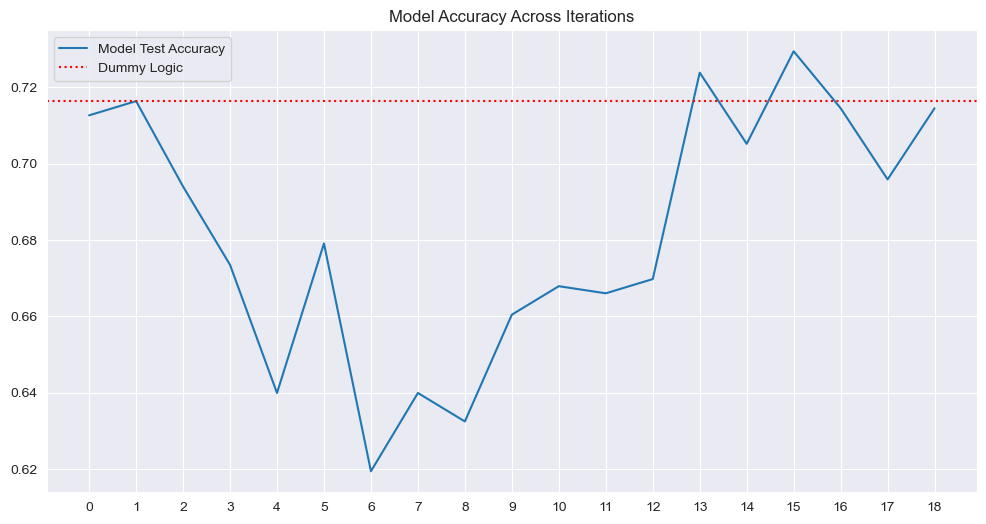

In [179]:
# Taking inventory of model performance across iterations up until this point

fig, ax = plt.subplots(figsize=(12,6))
Model.model_df["test_accuracy"].plot(kind="line", xticks = np.arange(0, 19, 1), \
                                     title="Model Accuracy Across Iterations", ax=ax, label="Model Test Accuracy")
ax.axhline(Model.model_df.loc[1, "test_accuracy"], linestyle=":", color="r", label="Dummy Logic")
plt.legend()
plt.grid(True);

### Next items to pursue:
I will now engineer some additional efficiency features:

- Net Rating for both teams
- The difference thereof
- Team A Off Eff - Team B Def Eff
- Team A Def Eff - Team B Off Eff

In [185]:
# Creating net rating feature, and also several differenced features
trial["Team_A_NetRating"] = trial["Team_A_Off_Eff"] - trial["Team_A_Def_Eff"]
trial["Team_B_NetRating"] = trial["Team_B_Off_Eff"] - trial["Team_B_Def_Eff"]

# Net Rating Diff
trial["NetRating_diff"] = trial["Team_A_NetRating"] - trial["Team_B_NetRating"]

# Offense - Defense
trial["Team_A_Off_diff_Team_B_Def"] = trial["Team_A_Off_Eff"] - trial["Team_B_Def_Eff"]

# Defense - Offense
trial["Team_A_Def_diff_Team_B_Off"] = trial["Team_A_Def_Eff"] - trial["Team_B_Off_Eff"]

# Inspection
trial[["Team_A_NetRating", "Team_B_NetRating", "NetRating_diff", "Team_A_Off_diff_Team_B_Def",\
      "Team_A_Def_diff_Team_B_Off"]].head(3)

,Team_A_NetRating,Team_B_NetRating,NetRating_diff,Team_A_Off_diff_Team_B_Def,Team_A_Def_diff_Team_B_Off
1136,-0.016306,-0.077455,0.061149,-0.097040,-0.003279
1137,0.127950,0.035543,0.092407,0.093015,-0.070479
1138,0.053442,0.092335,-0.038894,0.101123,-0.044655


In [931]:
team_names.query("TeamID == 1158 | TeamID == 1245")

,TeamID,TeamName,FirstD1Season,LastD1Season
57,1158,Col Charleston,1992,2024
144,1245,Kent,1985,2024


In [186]:
trial.shape

(2142, 86)

### Next model iterations:

In [189]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(trial, y, random_state=13, test_size=.25, \
                                                    shuffle=True, stratify=y)

In [192]:
# Fitting different models

pipe_model = Pipeline(steps=[
    ("ct", ct),
    ('model', LogisticRegression())
])

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867db10>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867d7e0>)])),
                ('model', LogisticRegression())])

In [195]:
# Model instantiations:

# rfc_with_net_ratings = Model("RFC with Net Rating Feats", pipe_model, X_train, X_test, y_train, y_test)

# logreg_with_net_ratings = Model("LogReg with Net Rating Feats", pipe_model, X_train, X_test, y_train, y_test)

Model.model_df.sort_values("test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
15,RFC - Diff Data State-13,0.720400,0.721189,0.726087,0.723122,0.548799,0.729478,0.718310,0.758364,0.737794,0.561726,0.783823
13,RFC - Diff Data,0.719779,0.719309,0.729806,0.723886,0.545105,0.723881,0.709343,0.762082,0.734767,0.559160,0.788028
1,Dummy Selection Logic,0.734745,0.739021,0.729864,0.734414,9.560770,0.716418,0.705263,0.747212,0.725632,10.221335,NaN
18,RFC - diff + eff,0.720396,0.720428,0.726102,0.723088,0.547357,0.714552,0.700000,0.754647,0.726297,0.570386,0.778045
16,LR - Stripped,0.738465,0.734507,0.755862,0.744232,0.514059,0.714552,0.701389,0.750929,0.725314,0.532195,0.803322
0,Baseline Logistic Regression,0.726635,0.728829,0.729829,0.728665,0.530540,0.712687,0.694915,0.762082,0.726950,0.536016,0.804617
14,LogReg - Diff Data,0.732859,0.731165,0.744690,0.737223,0.520316,0.705224,0.700361,0.721190,0.710623,0.528553,0.807123
19,RFC with Net Rating Feats,0.722262,0.721777,0.734752,0.726698,0.542004,0.703358,0.692308,0.736059,0.713514,0.566382,0.778567
20,LogReg with Net Rating Feats,0.732859,0.731447,0.743455,0.736821,0.520332,0.701493,0.695341,0.721190,0.708029,0.529007,0.805731
17,RFC - Stripped,0.729748,0.728910,0.739752,0.732968,0.536741,0.695896,0.676667,0.754647,0.713533,0.546866,0.792441


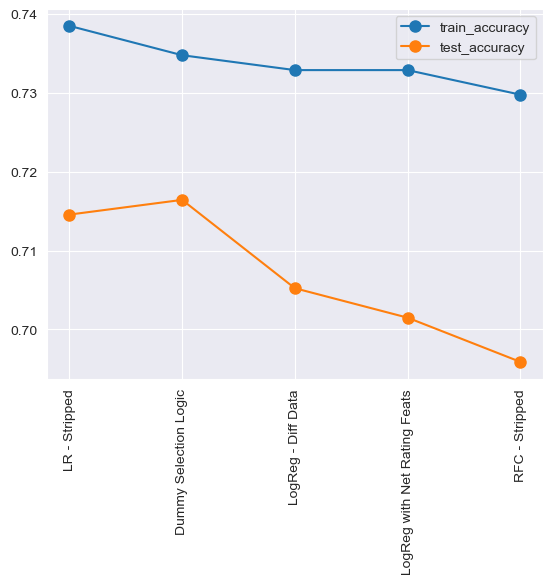

In [220]:
# Looking at the train_accuracy, and assessing model performance
Model.model_df.sort_values("train_accuracy", ascending=False)[:5][["train_accuracy", "test_accuracy"]]\
.reset_index(drop=True).plot(kind="line", marker="o", markersize=8)
plt.xticks(range(0, 5), Model.model_df.sort_values("train_accuracy", ascending=False)[:5]["name"], rotation=90)
plt.grid(True)

<div class= "alert alert-block alert-info" style="font-size: 2em">
    <b>Separating the Data by League: Men/Women </b>
</div>
I will re-use the league, seed, and win_pct features so that I can separate observations by league and generate the appropriate dummy predictions for each league as well. 

In [ ]:
dropped[["League"]]

In [246]:
# Recombining league labels and target value so that they may be split correctly
league_df = pd.concat([trial, dropped[["League", "Team_A_win_perc", "Team_A_Chalk_Seed", \
                                       'Team_B_win_perc', "Team_B_Chalk_Seed"]], y ], axis=1)

In [247]:
# Inspecting for verification
league_df

,Avg3ptAtt_diff,Avg3ptMade_diff,AvgFGAtt_diff,AvgFGMade_diff,AvgOppScore_diff,AvgPtDiff_diff,AvgTeamScore_diff,Avg_Assts_diff,Avg_Blocks_diff,Avg_Def_Rebs_diff,Avg_FT_Att_diff,Avg_FT_Made_diff,Avg_Fouls_diff,Avg_Off_Rebs_diff,Avg_Steals_diff,Avg_TO_diff,Chalk_Seed_diff,CloseGames_diff,CloseWins_diff,HomeLoss_diff,HomeWins_diff,LastFivePtDiff_diff,LastFiveWinPerc_diff,LastTenPtDiff_diff,LastTenWinPerc_diff,Loss_Total_diff,MaxLStreak_diff,MaxWStreak_diff,MedPtDiff_diff,NeutralLoss_diff,NeutralWins_diff,OTLoss_diff,OTWins_diff,OppAvg3ptAtt_diff,OppAvg3ptMade_diff,OppAvgFGAtt_diff,OppAvgFGMade_diff,OppAvg_Assts_diff,OppAvg_Blocks_diff,OppAvg_Def_Rebs_diff,OppAvg_FT_Att_diff,OppAvg_FT_Made_diff,OppAvg_Fouls_diff,OppAvg_Off_Rebs_diff,OppAvg_Steals_diff,OppAvg_TO_diff,OppTotal3ptAtt_diff,OppTotal3ptMade_diff,OppTotalFGAtt_diff,OppTotalFGMade_diff,OppTotal_Assts_diff,OppTotal_Def_Rebs_diff,OppTotal_FT_Att_diff,OppTotal_FT_Made_diff,OppTotal_Off_Rebs_diff,OppTotal_TO_diff,RoadLoss_diff,RoadWins_diff,StdDevOppScore_diff,StdDevTeamScore_diff,StdPtDiff_diff,Win_Total_diff,close_game_win_perc_diff,home_win_perc_diff,neutral_win_perc_diff,ot_win_perc_diff,road_win_perc_diff,win_perc_diff,League,Team_A_Conference,Team_A_Loc,Team_A_Relative_Diff_Trend,Team_A_Relative_Win_Trend,Team_B_Conference,Team_B_Loc,Team_B_Relative_Diff_Trend,Team_B_Relative_Win_Trend,Team_A_Off_Eff,Team_A_Def_Eff,Team_B_Off_Eff,Team_B_Def_Eff,Team_A_NetRating,Team_B_NetRating,NetRating_diff,Team_A_Off_diff_Team_B_Def,Team_A_Def_diff_Team_B_Off,League,Team_A_win_perc,Team_A_Chalk_Seed,Team_B_win_perc,Team_B_Chalk_Seed,Team_A_Win
1136,0.500000,-0.549425,-1.526437,0.354023,-7.614943,9.208046,1.593103,1.165517,-0.766667,1.627586,7.135632,1.434483,-0.803448,0.890805,-0.635632,-0.973563,0.0,4.0,2.0,1.0,1.0,7.6,0.156556,0.3,0.143506,-4.0,2.0,3.0,5.5,1.0,2.0,0.0,-3.0,2.408046,-0.087356,-0.565517,-2.126437,-2.095402,-1.641379,0.039080,-3.818391,-3.274713,2.943678,-1.790805,-0.827586,1.505747,93.0,5.0,44.0,-36.0,-47.0,24.0,-92.0,-83.0,-40.0,58.0,-6.0,2.0,-0.704848,0.465604,-5.304795,5.0,-0.057143,-0.047619,-0.250000,0.000000,0.208333,0.151724,Men,swac,N,Trending Up,On Trend,big_south,N,On Trend,On Trend,0.852459,0.868765,0.872044,0.949499,-0.016306,-0.077455,0.061149,-0.097040,-0.003279,Men,0.600000,16.0,0.448276,16.0,0
1137,4.588670,1.759852,9.852217,5.493842,7.112069,10.309113,17.421182,3.435961,1.248768,1.918719,5.448276,4.673645,1.853448,2.213054,1.602217,0.716749,-15.0,-2.0,0.0,0.0,5.0,-2.6,0.287097,5.3,0.291346,-7.0,-4.0,6.0,7.0,-1.0,-3.0,0.0,1.0,-1.483990,-0.747537,9.609606,3.598522,2.188424,-1.262315,1.423645,1.955665,0.662562,4.140394,3.520936,-1.139163,3.857143,-63.0,-28.0,214.0,78.0,48.0,18.0,39.0,8.0,89.0,95.0,-6.0,4.0,-1.024895,-1.615862,-0.045316,6.0,0.171429,0.033333,-0.600000,0.500000,0.416667,0.237685,Men,pac_ten,N,Trending Down,On Trend,aec,N,On Trend,On Trend,0.943456,0.815506,0.885985,0.850441,0.127950,0.035543,0.092407,0.093015,-0.070479,Men,0.892857,1.0,0.655172,16.0,1
1138,-7.482759,-3.000000,-3.103448,0.931034,3.344828,-1.896552,1.448276,-1.068966,-0.827586,-2.655172,3.310345,2.586207,0.655172,-0.379310,-2.172414,0.206897,3.0,0.0,0.0,1.0,-2.0,-8.8,-0.177696,-4.6,-0.138658,5.0,1.0,-7.0,-2.0,2.0,0.0,-1.0,2.0,-2.413793,-0.448276,-2.206897,1.517241,0.758621,0.758621,-3.034483,-0.206897,0.758621,2.931034,-1.344828,-1.275862,0.448276,-70.0,-13.0,-64.0,44.0,22.0,-88.0,-6.0,22.0,-39.0,13.0,2.0,-3.0,1.356380,3.244223,6.224259,-5.0,0.000000,-0.075000,-0.500000,1.000000,-0.236364,-0.172414,Men,pac_ten,N,Trending Down,Trending Down,cusa,N,On Trend,On Trend,0.910707,0.857265,0.901920,0.809584,0.053442,0.092335,-0.038894,0.101123,-0.044655,Men,0.620690,10.0,0.793103,7.0,1
1139,2.553814,1.142111,4.764890,2.076280,-8.908046,8.805643,-0.102403,1.197492,0.454545,-0.094044,-5.142111,-5.397074,-3.692790,0.292581,1.290491,-4.877743,-5.0,-3.0,-2.0,-1.0,6.0,-8.2,0.093533,-4.7,0.115693,-2.0,-1.0,4.0,6.0,0.0,2.0,0.0,1.0,0.406479,-0.086729,-2.597701,-2.466040,0.570533,0.092999,2.4

### Men's Data Only

In [250]:
# Men's Data
men = league_df.query("League == 'Men'").copy()
men.shape

(1315, 92)

In [251]:
# Creating a column for men dummy preds
men["dummy_preds"] = get_dummy_preds(men)
men[["dummy_preds", "Team_A_Win"]]

,dummy_preds,Team_A_Win
1136,1,0
1137,1,1
1138,0,1
1139,1,0
1140,0,0
...,...,...
2446,1,0
2447,0,0
2448,1,1
2449,1,1


In [255]:
men.columns[-10:]

Index(['NetRating_diff', 'Team_A_Off_diff_Team_B_Def',
       'Team_A_Def_diff_Team_B_Off', 'League', 'Team_A_win_perc',
       'Team_A_Chalk_Seed', 'Team_B_win_perc', 'Team_B_Chalk_Seed',
       'Team_A_Win', 'dummy_preds'],
      dtype='object')

### TT-Split with additional attention to features

In [257]:
X = men.drop(columns=["Team_A_Win", "dummy_preds"])
y = men["Team_A_Win"]

X.shape, y.shape

((1315, 91), (1315,))

In [259]:
# Train-test split for the men's data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, test_size=.25, \
                                                    shuffle=True, stratify=y)

In [263]:
# Creating a new row in the df tracking model performance

# Generate dummy preds
mens_dummy_dict = dummy_pred_df_entry(train_preds=get_dummy_preds(X_train), test_preds=get_dummy_preds(X_test))

# Add to the df
Model.model_df.loc[len(Model.model_df)] = mens_dummy_dict

# Rename for specificity
Model.model_df.loc[21, "name"] = "Men's Dummy Logic"

# Inspect
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Baseline Logistic Regression,0.726635,0.728829,0.729829,0.728665,0.530540,0.712687,0.694915,0.762082,0.726950,0.536016,0.804617
1,Dummy Selection Logic,0.734745,0.739021,0.729864,0.734414,9.560770,0.716418,0.705263,0.747212,0.725632,10.221335,NaN
2,Random Forest Classifier,0.717920,0.730259,0.703803,0.715201,0.553626,0.694030,0.688172,0.713755,0.700730,0.571604,0.768354
3,Extra Trees Classifier,0.717298,0.718752,0.721164,0.719473,0.553472,0.673507,0.664336,0.706320,0.684685,0.577592,0.765340
4,KNN Classifier,0.657528,0.660910,0.656759,0.658195,1.388824,0.639925,0.643939,0.631970,0.637899,1.968196,0.688644
5,XGBoost Classifier,0.715425,0.728680,0.695100,0.710133,0.702211,0.679104,0.673835,0.698885,0.686131,0.837950,0.760787
6,KNN| N=3,0.642588,0.649279,0.629461,0.638659,3.702864,0.619403,0.624521,0.605948,0.615094,4.345493,0.650669
7,KNN| N=5,0.657528,0.660910,0.656759,0.658195,1.388824,0.639925,0.643939,0.631970,0.637899,1.968196,0.688644
8,KNN| N=7,0.672464,0.681642,0.656729,0.668226,0.874990,0.632463,0.637405,0.620818,0.629002,1.255836,0.709292
9,KNN| N=9,0.674331,0.682854,0.657986,0.669700,0.741999,0.660448,0.652632,0.691450,0.671480,0.856465,0.726835


In [267]:
# Fitting different models

pipe_model = Pipeline(steps=[
    ("ct", ct),
    ('model', RandomForestClassifier(random_state=13))
])

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867db10>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867d7e0>)])),
                ('model', RandomForestClassifier(random_state=13))])

In [268]:
# Model Instantiation:

# LR
# mens_logreg1 = Model("Men's LR1 - diff+eff", pipe_model, X_train, X_test, y_train, y_test)

# RFC
# mens_rfc1 = Model("Men's RFC1 - diff+eff", pipe_model, X_train, X_test, y_train, y_test)

# Inspecting the Men's-only predictions
Model.model_df.loc[21:]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.6s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
21,Men's Dummy Logic,0.704868,0.708000,0.709419,0.708709,10.637630,0.677812,0.672316,0.712575,0.691860,11.612849,NaN
22,Men's LR1 - diff+eff,0.707932,0.714951,0.703414,0.708464,0.553428,0.659574,0.655367,0.694611,0.674419,0.602147,0.740963
23,Men's RFC1 - diff+eff,0.662293,0.663940,0.671354,0.667345,0.572735,0.665653,0.666667,0.682635,0.674556,0.608579,0.726843


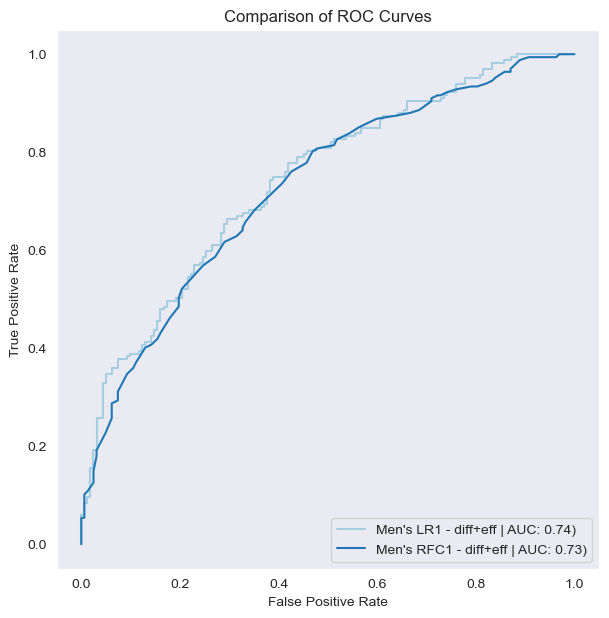

In [269]:
# Extremely similar performance 
compare_curves([mens_logreg1, mens_rfc1])

### Adding the Men's Rankings from Massey
These features are only available for the men's data, but add additional granular detail to the Chalk_Seed features. Even these features still have a select number of null values. I will impute the median value for each observation grouped by the Team_ID feature. 

In [304]:
# Men's Rankings - Median, Min, and Max as min == best and max == worst
mens_rankings = df.query("League == 'Men'")[["Team_A_MedianRanking", 'Team_A_BestRanking', 'Team_A_WorstRanking',\
                                            "Team_A_TeamID", "Team_B_MedianRanking", 'Team_B_BestRanking', \
                                             'Team_B_WorstRanking', "Team_B_TeamID"]]
# mens_rankings[mens_rankings.isna()]

In [306]:
# Grouping by Team_A/B Id median values to impute 

# Team_A Median Dictionaries for mapping

a_med_rank_dict = mens_rankings.groupby("Team_A_TeamID")["Team_A_MedianRanking"].median().to_dict()
a_best_rank_dict = mens_rankings.groupby("Team_A_TeamID")["Team_A_BestRanking"].median().to_dict()
a_worst_rank_dict = mens_rankings.groupby("Team_A_TeamID")["Team_A_WorstRanking"].median().to_dict()

# Team_B Median Dictionaries for mapping 

b_med_rank_dict = mens_rankings.groupby("Team_B_TeamID")["Team_B_MedianRanking"].median().to_dict()
b_best_rank_dict = mens_rankings.groupby("Team_B_TeamID")["Team_B_BestRanking"].median().to_dict()
b_worst_rank_dict = mens_rankings.groupby("Team_B_TeamID")["Team_B_WorstRanking"].median().to_dict()

In [312]:
# Fill Team A
mens_rankings["Team_A_MedianRanking"].fillna(mens_rankings["Team_A_TeamID"].map(a_med_rank_dict), inplace=True)
mens_rankings["Team_A_BestRanking"].fillna(mens_rankings["Team_A_TeamID"].map(a_best_rank_dict), inplace=True)
mens_rankings["Team_A_WorstRanking"].fillna(mens_rankings["Team_A_TeamID"].map(a_worst_rank_dict), inplace=True)

# Fill Team B
mens_rankings["Team_B_MedianRanking"].fillna(mens_rankings["Team_B_TeamID"].map(b_med_rank_dict), inplace=True)
mens_rankings["Team_B_BestRanking"].fillna(mens_rankings["Team_B_TeamID"].map(b_best_rank_dict), inplace=True)
mens_rankings["Team_B_WorstRanking"].fillna(mens_rankings["Team_B_TeamID"].map(b_worst_rank_dict), inplace=True)

In [313]:
# All of the Team_A values are now filled, but Team_B values still contain nulls for 1372 and 1111 Team ID

mens_rankings[mens_rankings["Team_B_BestRanking"].isna()]

,Team_A_MedianRanking,Team_A_BestRanking,Team_A_WorstRanking,Team_A_TeamID,Team_B_MedianRanking,Team_B_BestRanking,Team_B_WorstRanking,Team_B_TeamID
2011,9.0,3.0,30.0,1452,NaN,NaN,NaN,1372
2028,32.0,20.0,59.0,1323,NaN,NaN,NaN,1372
2252,220.0,146.0,278.0,1313,NaN,NaN,NaN,1111


In [317]:
# All of the Team_A values are now filled, but Team_B values still contain nulls for 1372 and 1111 Team ID

mens_rankings["Team_A_WorstRanking"].isna().sum()

0

In [320]:
# Accessing Team Names, finding that 1111 is Appalachian St. ->  | AND 1372 SF Austin -> 62
team_names = pd.read_csv("/Users/samalainabayeva/Desktop/FLAT_IRON!!!/NCAA_KAGGLE/march-machine-learning-mania-2024/MTeams.csv")
team_names.query("TeamID == 1372 | TeamID == 1111")

,TeamID,TeamName,FirstD1Season,LastD1Season
10,1111,Appalachian St,1985,2024
271,1372,SF Austin,1987,2024


In [322]:
# Appalachian State made the tournament in 2021, SF Austin Made the Tournament in 2016


df.query("Team_B_TeamID == 1111 | Team_B_TeamID == 1372") 

,DayNum,League,Season,Team_A_Avg3ptAtt,Team_A_Avg3ptMade,Team_A_AvgFGAtt,Team_A_AvgFGMade,Team_A_AvgOppScore,Team_A_AvgPtDiff,Team_A_AvgTeamScore,Team_A_Avg_Assts,Team_A_Avg_Blocks,Team_A_Avg_Def_Rebs,Team_A_Avg_FT_Att,Team_A_Avg_FT_Made,Team_A_Avg_Fouls,Team_A_Avg_Off_Rebs,Team_A_Avg_Steals,Team_A_Avg_TO,Team_A_BestRanking,Team_A_Chalk_Seed,Team_A_CloseGames,Team_A_CloseWins,Team_A_Coach,Team_A_Conference,Team_A_DiffTrend,Team_A_HomeLoss,Team_A_HomeWins,Team_A_LastFivePtDiff,Team_A_LastFiveWinPerc,Team_A_LastTenPtDiff,Team_A_LastTenWinPerc,Team_A_Loc,Team_A_Loss_Total,Team_A_MaxLStreak,Team_A_MaxWStreak,Team_A_MedPtDiff,Team_A_MedianRanking,Team_A_NeutralLoss,Team_A_NeutralWins,Team_A_OTLoss,Team_A_OTWins,Team_A_OppAvg3ptAtt,Team_A_OppAvg3ptMade,Team_A_OppAvgFGAtt,Team_A_OppAvgFGMade,Team_A_OppAvg_Assts,Team_A_OppAvg_Blocks,Team_A_OppAvg_Def_Rebs,Team_A_OppAvg_FT_Att,Team_A_OppAvg_FT_Made,Team_A_OppAvg_Fouls,Team_A_OppAvg_Off_Rebs,Team_A_OppAvg_Steals,Team_A_OppAvg_TO,Team_A_OppTotal3ptAtt,Team_A_OppTotal3ptMade,Team_A_OppTotalFGAtt,Team_A_OppTotalFGMade,Team_A_OppTotal_Assts,Team_A_OppTotal_Def_Rebs,Team_A_OppTotal_FT_Att,Team_A_OppTotal_FT_Made,Team_A_OppTotal_Off_Rebs,Team_A_OppTotal_TO,Team_A_Relative_Diff_Trend,Team_A_Relative_Win_Trend,Team_A_RoadLoss,Team_A_RoadWins,Team_A_Score,Team_A_Seed,Team_A_StdDevOppScore,Team_A_StdDevTeamScore,Team_A_StdPtDiff,Team_A_TeamID,Team_A_Total3ptAtt,Team_A_Total3ptMade,Team_A_TotalFGAtt,Team_A_TotalFGMade,Team_A_Total_Assts,Team_A_Total_Def_Rebs,Team_A_Total_FT_Att,Team_A_Total_FT_Made,Team_A_Total_Off_Rebs,Team_A_Total_TO,Team_A_WinTrend,Team_A_Win_Total,Team_A_WorstRanking,Team_A_close_game_win_perc,Team_A_home_win_perc,Team_A_neutral_win_perc,Team_A_ot_win_perc,Team_A_road_win_perc,Team_A_win_perc,Team_B_Avg3ptAtt,Team_B_Avg3ptMade,Team_B_AvgFGAtt,Team_B_AvgFGMade,Team_B_AvgOppScore,Team_B_AvgPtDiff,Team_B_AvgTeamScore,Team_B_Avg_Assts,Team_B_Avg_Blocks,Team_B_Avg_Def_Rebs,Team_B_Avg_FT_Att,Team_B_Avg_FT_Made,Team_B_Avg_Fouls,Team_B_Avg_Off_Rebs,Team_B_Avg_Steals,Team_B_Avg_TO,Team_B_BestRanking,Team_B_Chalk_Seed,Team_B_CloseGames,Team_B_CloseWins,Team_B_Coach,Team_B_Conference,Team_B_DiffTrend,Team_B_HomeLoss,Team_B_HomeWins,Team_B_LastFivePtDiff,Team_B_LastFiveWinPerc,Team_B_LastTenPtDiff,Team_B_LastTenWinPerc,Team_B_Loc,Team_B_Loss_Total,Team_B_MaxLStreak,Team_B_MaxWStreak,Team_B_MedPtDiff,Team_B_MedianRanking,Team_B_NeutralLoss,Team_B_NeutralWins,Team_B_OTLoss,Team_B_OTWins,Team_B_OppAvg3ptAtt,Team_B_OppAvg3ptMade,Team_B_OppAvgFGAtt,Team_B_OppAvgFGMade,Team_B_OppAvg_Assts,Team_B_OppAvg_Blocks,Team_B_OppAvg_Def_Rebs,Team_B_OppAvg_FT_Att,Team_B_OppAvg_FT_Made,Team_B_OppAvg_Fouls,Team_B_OppAvg_Off_Rebs,Team_B_OppAvg_Steals,Team_B_OppAvg_TO,Team_B_OppTotal3ptAtt,Team_B_OppTotal3ptMade,Team_B_OppTotalFGAtt,Team_B_OppTotalFGMade,Team_B_OppTotal_Assts,Team_B_OppTotal_Def_Rebs,Team_B_OppTotal_FT_Att,Team_B_OppTotal_FT_Made,Team_B_OppTotal_Off_Rebs,Team_B_OppTotal_TO,Team_B_Relative_Diff_Trend,Team_B_Relative_Win_Trend,Team_B_RoadLoss,Team_B_RoadWins,Team_B_Score,Team_B_Seed,Team_B_StdDevOppScore,Team_B_StdDevTeamScore,Team_B_StdPtDiff,Team_B_TeamID,Team_B_Total3ptAtt,Team_B_Total3ptMade,Team_B_TotalFGAtt,Team_B_TotalFGMade,Team_B_Total_Assts,Team_B_Total_Def_Rebs,Team_B_Total_FT_Att,Team_B_Total_FT_Made,Team_B_Total_Off_Rebs,Team_B_Total_TO,Team_B_WinTrend,Team_B_Win_Total,Team_B_WorstRanking,Team_B_close_game_win_perc,Team_B_home_win_perc,Team_B_neutral_win_perc,Team_B_ot_win_perc,Team_B_road_win_perc,Team_B_win_perc,Team_A_Win,Game_Point_Differential,Dummy_Predictions
2011,137,Men,2016,18.441176,6.058824,60.294118,27.264706,66.617647,12.588235,79.205882,14.764706,2.529412,23.264706,27.794118,18.617647,23.382353,15.911765,9.941176,14.000000,3.0,3.0,5.0,4.0,NaN,big_twelve,Uptrend,2.0,13.0,9.0,0.774939,7.9,0.769329,N,8.0,2.0,8.0,11.0,9.0,2.0,6.0,0.0,1.0,17.617647,5.852941,48.764706,20.852941,10.558824,3.676471,22.058824,26.735294,19.058824,23.176471,8.676471,6.735294,18.147059,599.0,199

In [324]:
mens_rankings[["Team_B_MedianRanking", "Team_B_BestRanking", "Team_B_WorstRanking"]].isna().sum()

Team_B_MedianRanking    3
Team_B_BestRanking      3
Team_B_WorstRanking     3
dtype: int64

In [325]:
# I found an NCAA site that ranked SF Austin 62nd, so I will fill all these remaining nulls with that approx value

mens_rankings["Team_B_MedianRanking"].fillna(62, inplace=True)
mens_rankings["Team_B_BestRanking"].fillna(62, inplace=True)
mens_rankings["Team_B_WorstRanking"].fillna(62, inplace=True)

mens_rankings[["Team_B_MedianRanking", "Team_B_BestRanking", "Team_B_WorstRanking"]].isna().sum()

Team_B_MedianRanking    0
Team_B_BestRanking      0
Team_B_WorstRanking     0
dtype: int64

In [327]:
# Final Sanity Check
mens_rankings.isna().sum()

Team_A_MedianRanking    0
Team_A_BestRanking      0
Team_A_WorstRanking     0
Team_A_TeamID           0
Team_B_MedianRanking    0
Team_B_BestRanking      0
Team_B_WorstRanking     0
Team_B_TeamID           0
dtype: int64

<hr style="border: 2px solid blue">

### Now, I will add the ranking data to the men's only training data

### TT-Split with additional attention to features

In [332]:
mens_rankings.drop(columns=["Team_A_TeamID", 'Team_B_TeamID'])

(1315, 6)

In [334]:
X = pd.concat([men.drop(columns=["Team_A_Win", "dummy_preds"]), \
               mens_rankings.drop(columns=["Team_A_TeamID", 'Team_B_TeamID'])], axis=1)
y = men["Team_A_Win"]

X.shape, y.shape

((1315, 97), (1315,))

In [340]:
# Train-test split for the men's data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, test_size=.25, \
                                                    shuffle=True, stratify=y)

In [341]:
# Inspect current data
Model.model_df[21:]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
21,Men's Dummy Logic,0.704868,0.708000,0.709419,0.708709,10.637630,0.677812,0.672316,0.712575,0.691860,11.612849,NaN
22,Men's LR1 - diff+eff,0.707932,0.714951,0.703414,0.708464,0.553428,0.659574,0.655367,0.694611,0.674419,0.602147,0.740963
23,Men's RFC1 - diff+eff,0.662293,0.663940,0.671354,0.667345,0.572735,0.665653,0.666667,0.682635,0.674556,0.608579,0.726843


In [346]:
# Fitting different models

pipe_model = Pipeline(steps=[
    ("ct", ct),
    ('model', RandomForestClassifier(random_state=13))
])

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867db10>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867d7e0>)])),
                ('model', RandomForestClassifier(random_state=13))])

In [347]:
# Model Instantiation:

# LR -> marginal DECREASE in train acc, INCREASE in test acc
# mens_logreg2 = Model("Men's LR2 - diff+eff+ratings", pipe_model, X_train, X_test, y_train, y_test)

# RFC -> improved results beyond any doubt, 
mens_rfc2 = Model("Men's RFC1 - diff+eff+ratings", pipe_model, X_train, X_test, y_train, y_test)

# Inspecting the Men's-only predictions
Model.model_df.loc[21:].sort_values("test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.5s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
25,Men's RFC1 - diff+eff+ratings,0.685638,0.693459,0.677333,0.685052,0.556785,0.693009,0.691860,0.712575,0.702065,0.603494,0.738209
21,Men's Dummy Logic,0.704868,0.708000,0.709419,0.708709,10.637630,0.677812,0.672316,0.712575,0.691860,11.612849,NaN
23,Men's RFC1 - diff+eff,0.662293,0.663940,0.671354,0.667345,0.572735,0.665653,0.666667,0.682635,0.674556,0.608579,0.726843
24,Men's LR2 - diff+eff+ratings,0.700810,0.708023,0.695394,0.700728,0.551716,0.662614,0.659091,0.694611,0.676385,0.606671,0.739225
22,Men's LR1 - diff+eff,0.707932,0.714951,0.703414,0.708464,0.553428,0.659574,0.655367,0.694611,0.674419,0.602147,0.740963


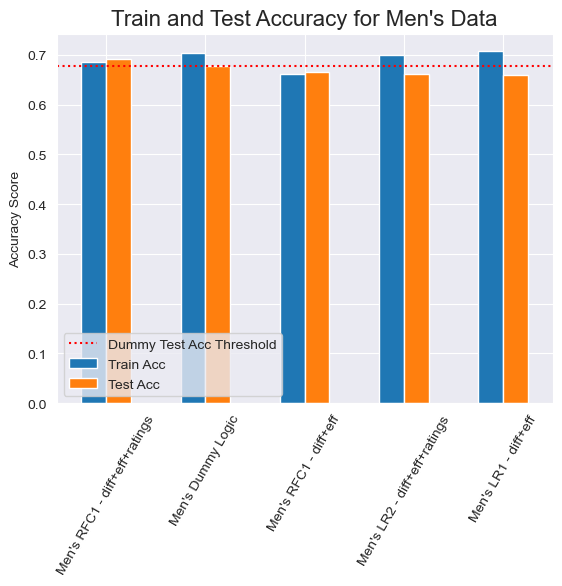

In [371]:
# Plotting Model Results thus far

Model.model_df.loc[21:].sort_values("test_accuracy", ascending=False).reset_index(drop=True)[["train_accuracy", 'test_accuracy']]\
.plot(kind='bar')
plt.axhline(Model.model_df.loc[21,"test_accuracy"], color="red", label="Dummy Test ACC Standard", linestyle=":")
plt.legend(["Dummy Test Acc Threshold", "Train Acc", "Test Acc"])
plt.xticks(range(5),\
           Model.model_df.loc[21:].sort_values("test_accuracy", ascending=False).reset_index(drop=True)["name"],\
          rotation=60)
plt.grid(True)
plt.title("Train and Test Accuracy for Men's Data", fontsize=16)
plt.ylabel("Accuracy Score");

### The inclusion of rankings data...
Seemed to have a negative effect on the logistic regression model and a positive effect on the tree based model. As you can see below, 3 of the top 5 feature importances used ranking data. All 6 rankings features were found in the top 10 features as well. This is out of 90 total features, showing some clear evidence that these features can be used to help generate better predictions.

In [372]:
# Extracting features
rfc_ratings_list = features_from_trees(mens_rfc2)

Top 5 Feature Importances
('Chalk_Seed_diff', 0.0380852372860776)
('Team_A_MedianRanking', 0.03336186031825447)
('Team_B_MedianRanking', 0.03028544765979395)
('Team_A_BestRanking', 0.026922072492396372)
('AvgPtDiff_diff', 0.026717174258415542)


In [396]:
# Investigating the top 10 features
rfc_ratings_list[20:30]

[('Avg_Off_Rebs_diff', 0.011946162620762946),
 ('Team_B_win_perc', 0.011927848829607538),
 ('HomeWins_diff', 0.011510715411511),
 ('Team_B_Def_Eff', 0.011463795571749057),
 ('Avg_Assts_diff', 0.01140816424316358),
 ('LastTenPtDiff_diff', 0.011270340663588634),
 ('StdDevTeamScore_diff', 0.01108216835752131),
 ('OppAvg_Assts_diff', 0.010979870553815826),
 ('AvgTeamScore_diff', 0.01087474889716062),
 ('StdDevOppScore_diff', 0.01082406125515915)]

<hr style="border: 2px solid blue">

<div class= 'alert alert-block alert-info'; style="font-size: 2em";>
    <b>Filtering for the Most Important Features:</b> Top-20 Features from RFC
</div>

In [379]:
### Trying to use the top-20 features from this previous model

# This list contains the 20 most significant features for the most recent RFC model
important_rfc_features = [i[0] for i in rfc_ratings_list[:20]]

In [386]:
# Train-test split for the men's data

X_train, X_test, y_train, y_test = train_test_split(X[important_rfc_features], y, random_state=13, test_size=.25, \
                                                    shuffle=True, stratify=y)

In [387]:
# Fitting different models

pipe_model = Pipeline(steps=[
    ("ct", ct),
    ('model', RandomForestClassifier(random_state=13))
])

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867db10>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867d7e0>)])),
                ('model', RandomForestClassifier(random_state=13))])

In [388]:
# Model Instantiations:

# RFC with the top 20 features from the highest scoring model so far
# mens_rfc2 = Model("Men's RFC3 - Top-20 Features", pipe_model, X_train, X_test, y_train, y_test)

Model.model_df.loc[21:].sort_values("test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.1s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
25,Men's RFC1 - diff+eff+ratings,0.685638,0.693459,0.677333,0.685052,0.556785,0.693009,0.691860,0.712575,0.702065,0.603494,0.738209
21,Men's Dummy Logic,0.704868,0.708000,0.709419,0.708709,10.637630,0.677812,0.672316,0.712575,0.691860,11.612849,NaN
26,Men's RFC3 - Top-20 Features,0.680567,0.682460,0.689374,0.685879,0.560122,0.671733,0.670520,0.694611,0.682353,0.614551,0.730576
23,Men's RFC1 - diff+eff,0.662293,0.663940,0.671354,0.667345,0.572735,0.665653,0.666667,0.682635,0.674556,0.608579,0.726843
24,Men's LR2 - diff+eff+ratings,0.700810,0.708023,0.695394,0.700728,0.551716,0.662614,0.659091,0.694611,0.676385,0.606671,0.739225
22,Men's LR1 - diff+eff,0.707932,0.714951,0.703414,0.708464,0.553428,0.659574,0.655367,0.694611,0.674419,0.602147,0.740963


By reducing the feature space, this RFC model produced worse results than the more complex model, but still ranked higher than the other models trained only on men's data.

In [399]:
# Adding the differenced columns containing basic counting stats

columns_to_add = ["Team_A_win_perc", "Team_B_win_perc", 'Team_A_Off_diff_Team_B_Def', 'Avg_Assts_diff', \
                 "Avg_Def_Rebs_diff", "Avg_Off_Rebs_diff", 'Avg_TO_diff']

### TT-Split with 27 features

In [402]:
# Train-test split for the men's data

X_train, X_test, y_train, y_test = train_test_split(X[important_rfc_features+columns_to_add], y, random_state=13,\
                                                    test_size=.25, shuffle=True, stratify=y)
X_train.shape

(986, 27)

In [423]:
# Fitting different models

pipe_model = Pipeline(steps=[
    ("ct", ct),
    ('model', LogisticRegression())
])

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867db10>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867d7e0>)])),
                ('model', LogisticRegression())])

In [424]:
# Model Instantiations:

# RFC with the top 20 features from the highest scoring model so far
# mens_rfc4 = Model("Men's RFC4 - Top-27 Features", pipe_model, X_train, X_test, y_train, y_test)

# mens_LR4 = Model("Men's LR - Top-27 Features", pipe_model, X_train, X_test, y_train, y_test)

Model.model_df.loc[21:].sort_values("test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.6s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
25,Men's RFC1 - diff+eff+ratings,0.685638,0.693459,0.677333,0.685052,0.556785,0.693009,0.691860,0.712575,0.702065,0.603494,0.738209
28,Men's LR - Top-27 Features,0.710973,0.714131,0.713475,0.712947,0.545699,0.680851,0.686747,0.682635,0.684685,0.591731,0.748170
21,Men's Dummy Logic,0.704868,0.708000,0.709419,0.708709,10.637630,0.677812,0.672316,0.712575,0.691860,11.612849,NaN
26,Men's RFC3 - Top-20 Features,0.680567,0.682460,0.689374,0.685879,0.560122,0.671733,0.670520,0.694611,0.682353,0.614551,0.730576
23,Men's RFC1 - diff+eff,0.662293,0.663940,0.671354,0.667345,0.572735,0.665653,0.666667,0.682635,0.674556,0.608579,0.726843
24,Men's LR2 - diff+eff+ratings,0.700810,0.708023,0.695394,0.700728,0.551716,0.662614,0.659091,0.694611,0.676385,0.606671,0.739225
22,Men's LR1 - diff+eff,0.707932,0.714951,0.703414,0.708464,0.553428,0.659574,0.655367,0.694611,0.674419,0.602147,0.740963
27,Men's RFC4 - Top-27 Features,0.676506,0.679182,0.683374,0.681254,0.556888,0.659574,0.658960,0.682635,0.670588,0.596906,0.738116


### Quick note.....
While the RFC with 90 features still has the best test score, this Logistic Regression model actually outperforms dummy logic on training and test data! I would consider this a victory. So far, no other model has been able to outperform dummy logic in both train AND test. It is very interesting to evaluate the different ranks of coefficients and feature importances in the zipped list below. 

"LastTenWinPerc_diff" has a negative coefficient in the LR model. This means that `as Team_A's last 10 win% gets larger than Team_B's it actually REDUCES THE LOG-ODDS of Team_A winning.` Intuitively, that makes little success, and leads me to believe that it might actually be a feature that could be omitted. 

In [431]:
dropped["Team_A_LastTenPtDiff"] - dropped["Team_B_LastTenPtDiff"]

1136     0.3
1137     5.3
1138    -4.6
1139    -4.7
1140    -3.3
        ... 
4029     7.2
4030    15.0
4031     3.5
4032    -7.5
4033    -9.7
Length: 2142, dtype: float64

In [425]:
# Extracting coefficients
lr_27feat_ratings_list = coefs_from_lr(mens_LR4)

Top 5 Feature Coefficients by Absolute Value
('Team_B_MedianRanking', 1.186239076440297)
('Team_A_WorstRanking', -1.1279689587327384)
('NetRating_diff', 1.1246448085130616)
('AvgPtDiff_diff', 1.1042531727629472)
('Avg_Blocks_diff', 1.003381380674249)


In [407]:
# Extracting Feature Importances
rfc_27feat_ratings_list = features_from_trees(mens_rfc4)

Top 5 Feature Importances
('Chalk_Seed_diff', 0.07787318525404917)
('Team_B_MedianRanking', 0.048218804516514044)
('AvgPtDiff_diff', 0.047589429772685744)
('Team_A_WorstRanking', 0.04582693718056321)
('NetRating_diff', 0.045572642442070016)


In [429]:
# Comparing the feature importances of the best model with 90 features and the most recent model with 27 features

# For formatted string only
idx=0

# loop through a list of a zipped object of features and coefficients to compare components
for i in list(zip(rfc_27feat_ratings_list, lr_27feat_ratings_list, rfc_ratings_list[:27])):
    idx+=1
    print(f"Most Important Feature #{idx}:")
    print("27 Features RFC:", i[0])
    print("27 Coefficients LR:", i[1])
    print("90 Features RFC:", i[2])
    print('*' *70)

Most Important Feature #1:
27 Features RFC: ('Chalk_Seed_diff', 0.07787318525404917)
27 Coefficients LR: ('Team_B_MedianRanking', 1.186239076440297)
90 Features RFC: ('Chalk_Seed_diff', 0.0380852372860776)
**********************************************************************
Most Important Feature #2:
27 Features RFC: ('Team_B_MedianRanking', 0.048218804516514044)
27 Coefficients LR: ('Team_A_WorstRanking', -1.1279689587327384)
90 Features RFC: ('Team_A_MedianRanking', 0.03336186031825447)
**********************************************************************
Most Important Feature #3:
27 Features RFC: ('AvgPtDiff_diff', 0.047589429772685744)
27 Coefficients LR: ('NetRating_diff', 1.1246448085130616)
90 Features RFC: ('Team_B_MedianRanking', 0.03028544765979395)
**********************************************************************
Most Important Feature #4:
27 Features RFC: ('Team_A_WorstRanking', 0.04582693718056321)
27 Coefficients LR: ('AvgPtDiff_diff', 1.1042531727629472)
90 Feat

<hr style="border: 2px solid blue">

### Adding Rebound Differential

In [443]:
team_a_rebs = (dropped.query("League == 'Men'")["Team_A_Avg_Def_Rebs"] +\
               dropped.query("League == 'Men'")["Team_A_Avg_Off_Rebs"])

team_b_rebs = (dropped.query("League == 'Men'")["Team_B_Avg_Def_Rebs"] +\
               dropped.query("League == 'Men'")["Team_B_Avg_Off_Rebs"])

In [447]:
X["Rebound_diff"] = team_a_rebs - team_b_rebs

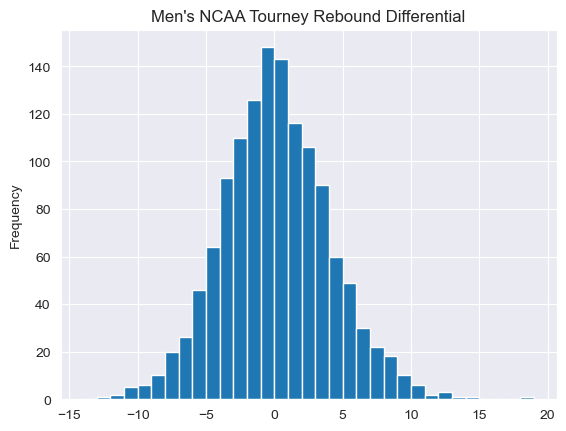

In [477]:
X["Rebound_diff"].plot(kind="hist", bins=np.arange(-14, 20, 1), grid=True, \
                       title="Men's NCAA Tourney Rebound Differential");

### TT-Split and Model Eval

In [455]:
# Train-test split for the men's data

X_train, X_test, y_train, y_test = train_test_split(X[important_rfc_features+columns_to_add+["Rebound_diff"]], \
                                                    y, random_state=13, test_size=.25, shuffle=True, stratify=y)
X_train.shape

(986, 28)

In [457]:
# Fitting different models

pipe_model = Pipeline(steps=[
    ("ct", ct),
    ('model', LogisticRegression())
])

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867db10>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f2867d7e0>)])),
                ('model', LogisticRegression())])

In [458]:
# Model instantiations

# LR with rebound differential
# logreg_reb_diff = Model("LR with Reb_diff, 28 features", pipe_model, X_train, X_test, y_train, y_test)

Model.model_df[21:].sort_values("test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.4s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
25,Men's RFC1 - diff+eff+ratings,0.685638,0.693459,0.677333,0.685052,0.556785,0.693009,0.691860,0.712575,0.702065,0.603494,0.738209
28,Men's LR - Top-27 Features,0.710973,0.714131,0.713475,0.712947,0.545699,0.680851,0.686747,0.682635,0.684685,0.591731,0.748170
29,"LR with Reb_diff, 28 features",0.710973,0.714131,0.713475,0.712947,0.545772,0.680851,0.686747,0.682635,0.684685,0.591722,0.748244
21,Men's Dummy Logic,0.704868,0.708000,0.709419,0.708709,10.637630,0.677812,0.672316,0.712575,0.691860,11.612849,NaN
26,Men's RFC3 - Top-20 Features,0.680567,0.682460,0.689374,0.685879,0.560122,0.671733,0.670520,0.694611,0.682353,0.614551,0.730576
23,Men's RFC1 - diff+eff,0.662293,0.663940,0.671354,0.667345,0.572735,0.665653,0.666667,0.682635,0.674556,0.608579,0.726843
24,Men's LR2 - diff+eff+ratings,0.700810,0.708023,0.695394,0.700728,0.551716,0.662614,0.659091,0.694611,0.676385,0.606671,0.739225
22,Men's LR1 - diff+eff,0.707932,0.714951,0.703414,0.708464,0.553428,0.659574,0.655367,0.694611,0.674419,0.602147,0.740963
27,Men's RFC4 - Top-27 Features,0.676506,0.679182,0.683374,0.681254,0.556888,0.659574,0.658960,0.682635,0.670588,0.596906,0.738116


### Notes
The inclusion of a rebound differential statistic **VERY MARGINALLY** improves model AUC and test_logloss compared to the previous Logistic Regression model.  

<hr style="border: 2px solid blue">

##### File saving for convenience

<hr style="border: 2px solid blue">

In [472]:
# Saving working items to csv for easier resumption

# Features
X[important_rfc_features+columns_to_add+["Rebound_diff"]].to_csv(os.path.join(path, "Best_Features_Mid_Process.csv"))

# Model Logs
Model.model_df.to_csv(os.path.join(path, "Model_DF_Mid_Process.csv"))

<hr style="border:2px solid blue">

<div class = "alert alert-info alert-block" style="font-size: 2em";>
    <b>Feature Engineering and Selection</b>
    </div>


## The following section will be dense. Much of this process was experimental:

### Adding an interaction term between median ranking and last-10 winning %
I think that adding a feature like this might capture the overall perceptions of a team's quality and its recent performance trends. I'll then add the new feature to the "X" data and evaluated performance. I will also use this new feature with a log-transformation first to normalize the distribution of features, and then **without transformation** second. 

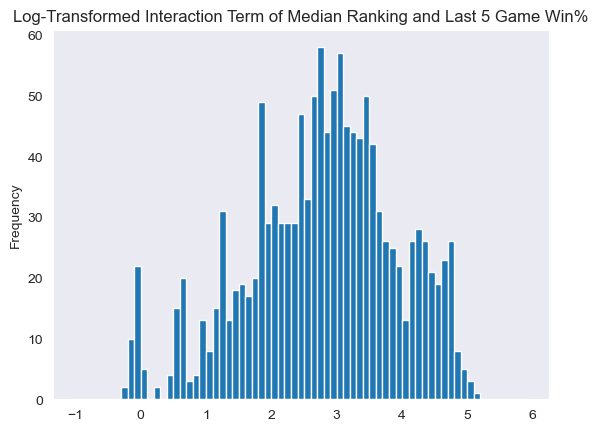

In [518]:
# 1st
# Create the term applying log transformation to create a normal distribution of values
interaction = np.log(df.query("League == 'Men'")["Team_A_MedianRanking"] * \
                     df.query("League == 'Men'")["Team_A_LastTenWinPerc"])

# Plot for inspection of the feature
interaction.plot(kind='hist', bins=np.arange(-1, 6, .1),\
                 title= "Log-Transformed Interaction Term of Median Ranking and Last 10 Game Win%");

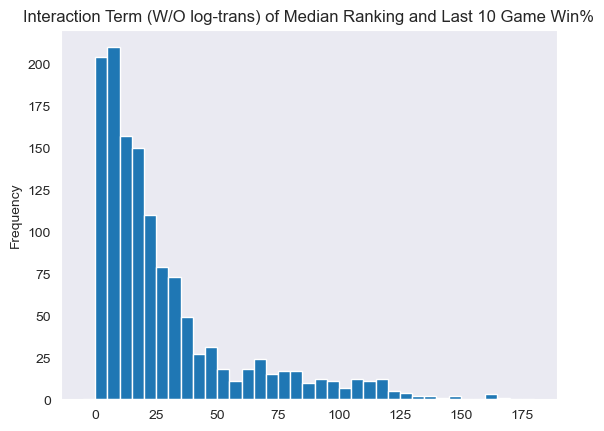

In [520]:
# Create the term WITHOUT applying log transformation to create a normal distribution of values
interaction = df.query("League == 'Men'")["Team_A_MedianRanking"] * \
                     df.query("League == 'Men'")["Team_A_LastTenWinPerc"]

# Plot for inspection of the feature
interaction.plot(kind='hist', bins=np.arange(-5, 185, 5),\
                 title= "Interaction Term (W/O log-trans) of Median Ranking and Last 10 Game Win%");

In [507]:
# Adding the feature to our working X feature df

X["Interaction_Rank_Last10"] = interaction

# Inspection of log values
X[["Interaction_Rank_Last10"]]

,Interaction_Rank_Last10
1136,4.992688
1137,-0.094293
1138,3.540949
1139,3.052096
1140,3.578807
...,...
2446,1.870734
2447,2.589924
2448,1.801025
2449,2.666547


In [522]:
# Adding the feature to our working X feature df
X["Interaction_Rank_Last10"] = interaction

# Inspection of un-transformed values
X[["Interaction_Rank_Last10"]]

,Interaction_Rank_Last10
1136,147.331977
1137,0.910016
1138,34.499633
1139,21.159646
1140,35.830762
...,...
2446,6.493060
2447,13.328761
2448,6.055853
2449,14.390193


### Creating multiple additional interaction terms

In [535]:
# Create the term applying log transformation to create a normal distribution of values
interaction1 = np.log(df.query("League == 'Men'")["Team_A_MedianRanking"] * \
                     df.query("League == 'Men'")["Team_A_LastTenWinPerc"])

interaction2 = np.log(df.query("League == 'Men'")["Team_A_MedianRanking"] * \
                     df.query("League == 'Men'")["Team_A_LastFiveWinPerc"])


interaction3 = df.query("League == 'Men'")["Team_A_MedianRanking"] * \
                     df.query("League == 'Men'")["Team_A_LastFiveWinPerc"]

X['Interaction_Rank_Last10_log'] = interaction1
X['Interaction_Rank_Last5_log'] = interaction2
X['Interaction_Rank_Last5'] = interaction3

In [536]:
# List of features to include in the model
current_features = list(X[important_rfc_features+columns_to_add+["Rebound_diff"]].columns)
print('Before:',len(current_features))

# Adding the interaction term
current_features.append("Interaction_Rank_Last10")
print('After:', len(current_features))

Before: 28
After: 29


In [543]:
# Adding the 3 newest interaction terms:
print("Before adding 3 other terms:", len(current_features))

# Add terms
current_features.extend(['Interaction_Rank_Last10_log', 'Interaction_Rank_Last5_log', 'Interaction_Rank_Last5'])

print("After adding 3 other terms:", len(current_features))


Before adding 3 other terms: 29
After adding 3 other terms: 32


In [571]:
# Removing the features without log transformations

# current_features.remove("Interaction_Rank_Last5")
# current_features.remove("Interaction_Rank_Last10")
# current_features.remove('Interaction_Rank_Last10_log')

# BECAUSE THIS TERMS CAUSED OVERFITTING, I am removing each version of it
current_features.remove('Interaction_Rank_Last5_log')

In [572]:
# 28 Features have led to the best performing model so far, 6 total rankings + 2 Chalk Seeds, a lot of ranked data

len(current_features)

28

In [585]:
df.query("League == 'Men'")["Team_A_LastTenWinPerc"]

1136    0.568849
1137    0.910016
1138    0.650936
1139    0.881652
1140    0.612492
          ...   
2446    0.763889
2447    0.650183
2448    0.756982
2449    0.799455
2450    0.756982
Name: Team_A_LastTenWinPerc, Length: 1315, dtype: float64

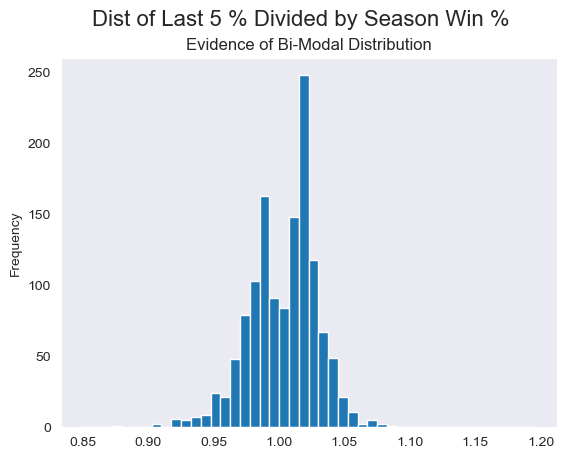

In [591]:
X["Team_A_5gm_div_TotalWinPerc"] = df.query("League == 'Men'")["Team_A_LastFiveWinPerc"] / X["Team_A_win_perc"]
X["Team_A_10gm_div_TotalWinPerc"] = df.query("League == 'Men'")["Team_A_LastTenWinPerc"] / X["Team_A_win_perc"]

X["Team_A_5gm_div_TotalWinPerc"].plot(kind="hist", bins=np.arange(.85, 1.2, .0075),\
                                      title="Evidence of Bi-Modal Distribution")
plt.suptitle("Dist of Last 5 % Divided by Season Win %", fontsize=16);

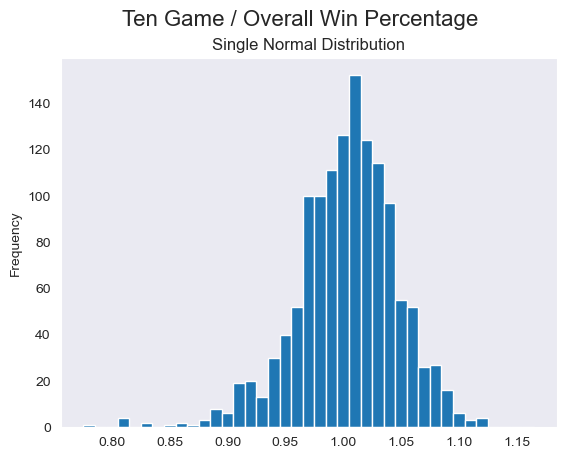

In [600]:
X["Team_A_10gm_div_TotalWinPerc"].plot(kind="hist", bins=np.arange(.775, 1.175, 0.01),  \
                                       title="Single Normal Distribution")
plt.suptitle("Ten Game / Overall Win Percentage", fontsize=16);

In [601]:
current_features.extend(["Team_A_10gm_div_TotalWinPerc", 'Team_A_5gm_div_TotalWinPerc'])

In [615]:
# Removing the features that reduce performance

current_features.remove('Team_A_10gm_div_TotalWinPerc')
current_features.remove('Team_A_5gm_div_TotalWinPerc')


### Engineer These Features

**Steals-Related:**

AvgFGMade_diff Avg_Steals_diff

MedPtDiff_diff Avg_Steals_diff

Avg_Steals_diff Avg_Assts_diff

**Turnovers and point differential**

'MedPtDiff_diff Avg_TO_diff'

**Two Net-Ratings Adjacent Terms**

MedPtDiff_diff Team_A_Def_diff_Team_B_Off

Team_B_NetRating Team_A_Def_diff_Team_B_Off

**(Team A O-Rating - Team_B D-Rating) * Avg Offensive Rebound Difference**

Team_A_Off_diff_Team_B_Def Avg_Off_Rebs_diff

In [ ]:
X["Team_A_Def_diff_Team_B_Off"]

In [732]:
# Interaction Term Feature Creation

# FGM_diff x Steals_diff
X["Int_AvgFGM_x_Avg_Steals_diff"] = X["AvgFGMade_diff"] * X["Avg_Steals_diff"]

# Pt_Diff_diff x Steals_diff
X["Int_Med_Pt_Diff_diff_x_Avg_Steals_diff"] = X["MedPtDiff_diff"] * X["Avg_Steals_diff"]

# Assists_diff x Steals_diff
X["Int_Avg_Assts_diff_x_Avg_Steals_diff"] = X["Avg_Assts_diff"] * X["Avg_Steals_diff"]

# MedPt_Diff_diff x Avg_TO_diff
X["Int_MedPtDiff_diff_x_Avg_TO_diff"] = X["MedPtDiff_diff"] * X["Avg_TO_diff"]

# MedPt_Diff_diff x Team_A_Def_diff_Team_B_Off
X["Int_MedPt_Diff_diff_x_Team_A_Def_diff_Team_B_Off"] = X["MedPtDiff_diff"] * X['Team_A_Def_diff_Team_B_Off']

# Team_B_NetRating_x_Team_A_Def_diff_Team_B_Off
X["Int_Team_B_NetRating_x_Team_A_Def_diff_Team_B_Off"] = X['Team_A_Def_diff_Team_B_Off'] * X["Team_B_NetRating"]

# Team_A_Off_diff_Team_B_Def_x_Avg_Off_Rebs_diff
X["Int_Team_A_Off_diff_Team_B_Def_x_Avg_Off_Rebs_diff"] = X["Team_A_Off_diff_Team_B_Def"] * X['Avg_Off_Rebs_diff']

In [790]:
current_features = current_features[:28]

In [ ]:
# Int_Avg_Assts_diff_x_Avg_Steals_diff
# Int_MedPtDiff_diff_x_Avg_TO_diff
# Int_MedPt_Diff_diff_x_Team_A_Def_diff_Team_B_Off
# Int_Team_A_Off_diff_Team_B_Def_x_Avg_Off_Rebs_diff

In [792]:
current_features.extend([
                        'Int_Avg_Assts_diff_x_Avg_Steals_diff', 'Int_MedPtDiff_diff_x_Avg_TO_diff',\
                        'Int_MedPt_Diff_diff_x_Team_A_Def_diff_Team_B_Off', \
                        'Int_Team_A_Off_diff_Team_B_Def_x_Avg_Off_Rebs_diff'])

In [787]:
# Adding Conferences
# current_features.extend(['Team_A_Conference', 'Team_B_Conference'])

# Had a negative impact on model performance
current_features.remove('Team_A_Conference')
current_features.remove('Team_B_Conference')

### Final Interactions After Fitting Polynomial Features to the Full Feature Set

In [824]:
# 'Avg3ptAtt_diff Avg3ptMade_diff'
# 'Avg_Blocks_diff StdPtDiff_diff'
# 'CloseWins_diff close_game_win_perc_diff'

# 3pt att vs makes
X["Int_Avg3ptAtt_diff_x_Avg3ptMade_diff"] = X["Avg3ptAtt_diff"] * X["Avg3ptMade_diff"]

# Blocks v std_dev of point differential
X["Int_Avg_Blocks_diff_x_StdPtDiff_diff"] = X["Avg_Blocks_diff"] * X["StdPtDiff_diff"]

# Close wins diff vs close game win % diff
X["Int_CloseWins_diff_x_close_game_win_perc_diff"] = X["CloseWins_diff"] * X["close_game_win_perc_diff"]


In [825]:
current_features.extend(["Int_Avg3ptAtt_diff_x_Avg3ptMade_diff", "Int_Avg_Blocks_diff_x_StdPtDiff_diff",\
                        "Int_CloseWins_diff_x_close_game_win_perc_diff"])

In [826]:
# 28 Features have led to the best performing model so far, 6 total rankings + 2 Chalk Seeds, a lot of ranked data

len(current_features)

35

In [804]:
# current_features.extend(["Interaction_Rank_Last5_log"])
current_features.remove('Interaction_Rank_Last5_log')

In [827]:
# TT-Split

X_train, X_test, y_train, y_test = train_test_split(X[current_features], y, random_state=13, test_size=.25, \
                                                   stratify=y)

In [828]:
from sklearn.preprocessing import PolynomialFeatures

# Creating Pipeline objects

    # Adding Polynomial Features - then removing it after selecting specific interactions
#     ("pf", PolynomialFeatures(interaction_only=True)),

numeric_pipe = Pipeline(steps=[
    ("si", SimpleImputer(add_indicator=True, strategy="median")),
#     ("pf", PolynomialFeatures(interaction_only=True)),
    ("mms", MinMaxScaler())
])

cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

ct = ColumnTransformer(transformers=[
    ("num_pipe", numeric_pipe, selector(dtype_include=np.number)),
    ('cat_pipe', cat_pipe, selector(dtype_exclude=np.number))
])


In [829]:
# Pipeline

pipe_model = Pipeline(steps=[
    ("ct", ct),
    ("model", LogisticRegression())
])

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9d23864610>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9d238645b0>)])),
                ('model', LogisticRegression())])

In [832]:
# Instantiation: Permutations of interaction between median rank and last 5/10 game win % ALWAYS caused overfitting

# logreg_w_int_term = Model("LR with Int Term (29 features)", pipe_model, X_train, X_test, y_train, y_test)

# logreg_w_int_term = Model("LR with Int Term (w/o log-trans)", pipe_model, X_train, X_test, y_train, y_test)

# logreg_w_multiple_int_terms = Model("LR with Multiple Ints", pipe_model, X_train, X_test, y_train, y_test)

# logreg_w_log_only_int_terms = Model("LR with Multiple Log-trans", pipe_model, X_train, X_test, y_train, y_test)

# logreg_w_last5_log_only = Model("LR with Last-5 Log-Int Only", pipe_model, X_train, X_test, y_train, y_test)

# logreg_win_trend_interactions = Model("LR with Win Trend/Overall%", pipe_model, X_train, X_test, y_train, y_test)


# RFC's continue to struggle with reduced list of features
# rfc_win_trend_interactions = Model("RFC with Win Trend/Overall%", pipe_model, X_train, X_test, y_train, y_test)


# logreg_polynomial = Model("LR with Polynomial Features Int-Only", pipe_model, X_train, X_test, y_train, y_test)

# logreg_select_interactions = Model("LR with 7 Int-Terms (35 feats)", pipe_model, X_train, X_test, y_train, y_test)

# logreg_REAL_select_interactions = Model("LR CORRECTED 7 Int-Terms (35 feats)", pipe_model, X_train, X_test, y_train, y_test)



# THIS MODEL REPRESENTS SOME REAL PROGRESS!!!!!!
# logreg_REAL_select_interactions = Model("LR Select 4 Int-Terms (32 feats)", pipe_model, X_train, X_test, y_train, y_test)

# ALL FEATURES INCLUDED
# logreg_ALL_features = Model("LR All Features", pipe_model, X_train, X_test, y_train, y_test)

# Adding conference features -> increased OVERFITTING
# logreg_conferences_added = Model("LR 4INTS, Conferences Included", pipe_model, X_train, X_test, y_train, y_test)

# OVERFIT AGAIN With the inclusion of 1 additional term
# logreg_33_feats = Model("LR 4INTS, 1 5game Log Trans", pipe_model, X_train, X_test, y_train, y_test)


# ALL FEATURES POLYNOMIAL INTERACTIONS ONLY
# all_features_poly = Model("LR Polynomial All Features", pipe_model, X_train, X_test, y_train, y_test)


# 3 Additional Int Terms 35 features total
# logreg_35_feats = Model("LR 7INTS, 35 Features after MASS-POLY", pipe_model, X_train, X_test, y_train, y_test)

Model.model_df.loc[21:].sort_values('test_accuracy', ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
25,Men's RFC1 - diff+eff+ratings,0.685638,0.693459,0.677333,0.685052,0.556785,0.693009,0.691860,0.712575,0.702065,0.603494,0.738209
46,"LR 7INTS, 35 Features after MASS-POLY",0.718079,0.726516,0.709515,0.717001,0.540007,0.689970,0.690058,0.706587,0.698225,0.586344,0.753937
41,LR Select 4 Int-Terms (32 feats),0.716049,0.718121,0.721556,0.718959,0.541868,0.689970,0.692308,0.700599,0.696429,0.586904,0.752680
43,"LR 4INTS, Conferences Included",0.720110,0.725564,0.717434,0.721070,0.554802,0.683891,0.680000,0.712575,0.695906,0.604127,0.745731
35,LR with Win Trend/Overall%,0.711978,0.714881,0.715455,0.714475,0.546757,0.680851,0.686747,0.682635,0.684685,0.591104,0.748503
...,...,...,...,...,...,...,...,...,...,...,...,...
23,Men's RFC1 - diff+eff,0.662293,0.663940,0.671354,0.667345,0.572735,0.665653,0.666667,0.682635,0.674556,0.608579,0.726843
24,Men's LR2 - diff+eff+ratings,0.700810,0.708023,0.695394,0.700728,0.551716,0.662614,0.659091,0.694611,0.676385,0.606671,0.739225
22,Men's LR1 - diff+eff,0.707932,0.714951,0.703414,0.708464,0.553428,0.659574,0.655367,0.694611,0.674419,0.602147,0.740963
27,Men's RFC4 - Top-27 Features,0.676506,0.679182,0.683374,0.681254,0.556888,0.659574,0.658960,0.682635,0.670588,0.596906,0.738116


### Interaction Term Eval:

##### Median Ranking and Last 5/10 Game Win %
The interaction term and log transformation only managed to contribute to *over-fitting* of the LR model. I doubled back and evaluated performance without transformation of the term as well, as well as several other permutations. 

My observations are that the interaction term led to over-fitting in each permutation. It's inclusion improved the train accuracy, but failed to generalize well. 

##### Last 5 Win / Team Win %
The next term I tried to create was by measuring a Team's recent performance against its season-long performance. This led to more over-fitting once again.

##### Polynomial Features -> Coef only
I'll also modify the column-transformer, and add Polynomial Features to the numeric values. The first iteration with polynomial features produced poorer results on train and test data when compared to the 28-feature model that is currently the best candidate model. The inclusion of all coef-interactions reduced performance. I selected 7 of the largest-coefficient interaction terms, and they actually contributed to an extremely small increase in model performance. **`The increase of performance comes with the cost of making the model even more complex with negligible accuracy improvement.`** Also interestingly, the *Team Rankings* leaped back to the top of the coefficient list when only 7 were included. 

##### 4 Interaction Terms:

Selecting 4 separate terms that use distinct statistics led to an improvement of the model. In the below matrices, you can see that I was able to achieve **`3 more True Positives` and `3 Fewer False Negatives`**. This is the most positive outcome that I have been able to achieve so far. 

##### 3 Additional Terms:
I included all features and utilized PolynomialFeatures in the sklearn pipeline. I then examined the coefficients of these interaction terms. I selected 3 additional terms to include based on the magnitude of their coefficients and the fact that the statistics involved were not yet represented in the interaction terms I had previously included. The result of the new features was a somewhat lateral move. I was able to predict **`1 more True Positive, but also 1 more False Positive.`** That being said, *`all of the other evaluation metrics were better`* than the previous best model.

### Saving To File

In [913]:
# Features
X[current_features].to_csv(os.path.join(path, "Best_Features_End_of_Process.csv"))

# Model Logs
Model.model_df.to_csv(os.path.join(path, "Model_DF_End_of_Process.csv"))

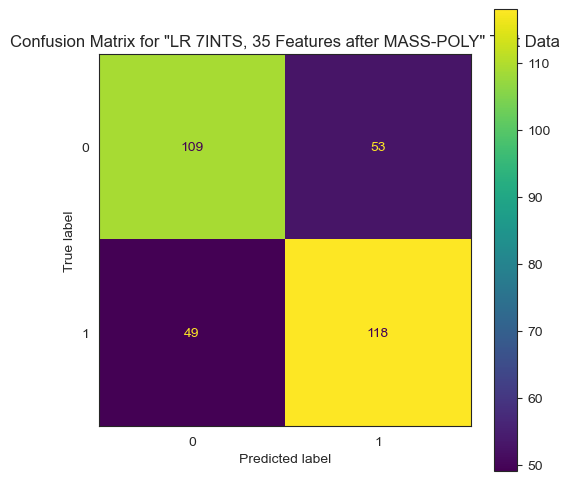

In [833]:
# Lateral move... Very Slight Improvement
logreg_35_feats.confusion_matrix()

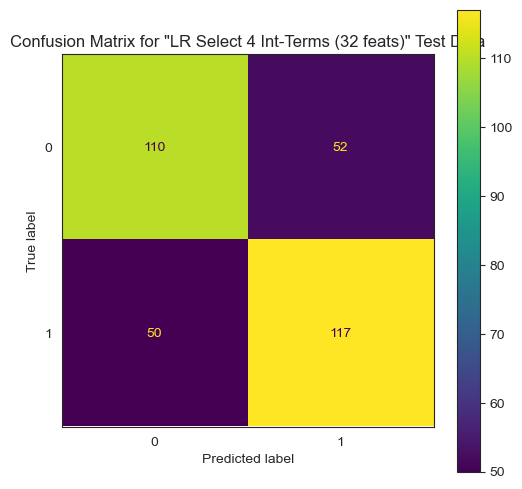

In [753]:
# Best Model So Far
logreg_REAL_select_interactions.confusion_matrix()

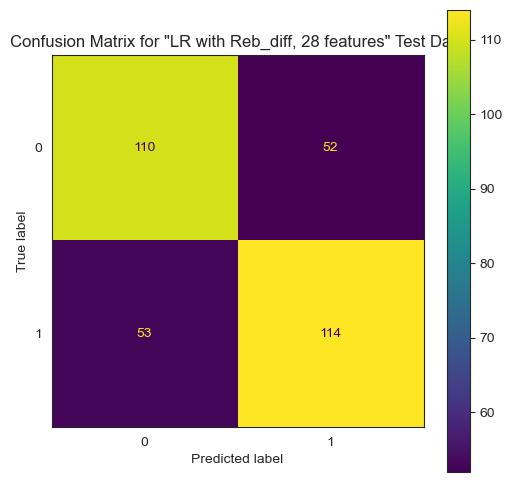

In [754]:
# Previous Best Model
Model.model_list[27].confusion_matrix()

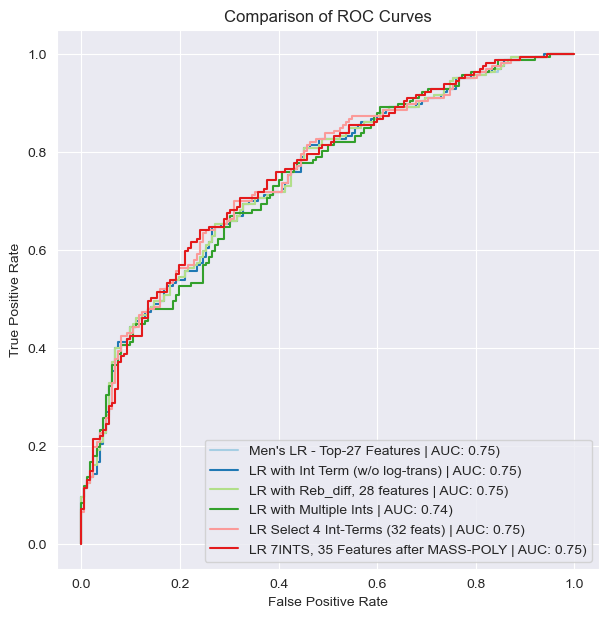

In [834]:
# Visual Inspection
compare_curves([Model.model_list[26],logreg_w_int_term, Model.model_list[27], logreg_w_multiple_int_terms, \
                logreg_REAL_select_interactions, logreg_35_feats])
plt.grid(True)

<hr style= "border: 2px solid blue">

### The model trained using 4 interaction terms, 32 total features stands out (6th best on this plot), and was used as a basis to improve from.

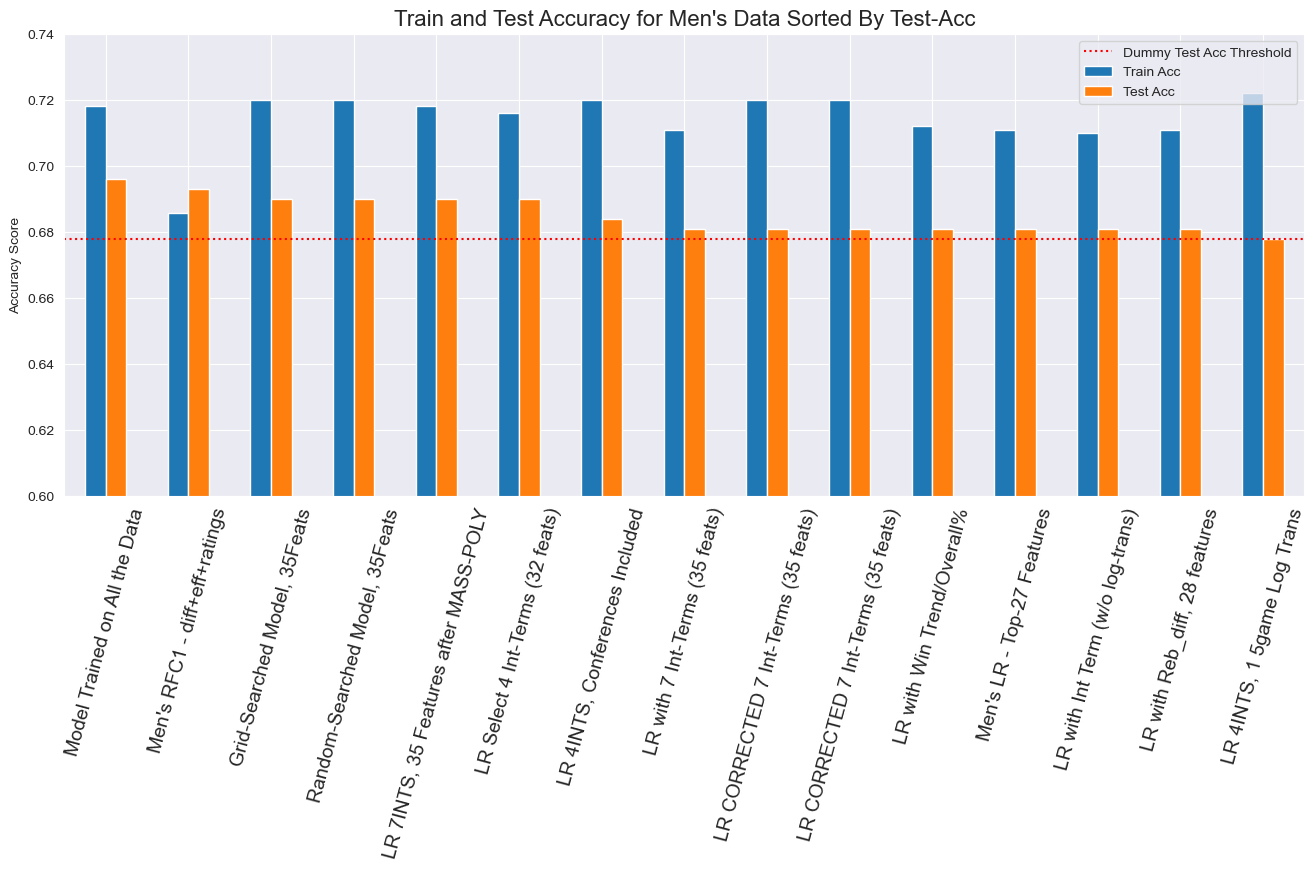

In [914]:
# Plotting the Top-10 Models/Logics by Train and Test Scores

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(16,6))

# Plotting Train/Test Accuracy
Model.model_df.loc[21:].sort_values("test_accuracy", ascending=False)[:15]\
    .reset_index(drop=True)[["train_accuracy", 'test_accuracy']]\
    .plot(kind='bar', ax=ax)

# Horizontal Line Indicating Baseline Performance to Beat
plt.axhline(Model.model_df.loc[21,"test_accuracy"], color="red", label="Dummy Test ACC Standard", linestyle=":")

# Legend
plt.legend(["Dummy Test Acc Threshold", "Train Acc", "Test Acc"])

# Formatting
plt.xticks(range(15),\
           Model.model_df.loc[21:].sort_values("test_accuracy", ascending=False)[:15].reset_index(drop=True)["name"],\
          rotation=75, fontsize=14)
plt.grid(True)

# Title
plt.title("Train and Test Accuracy for Men's Data Sorted By Test-Acc", fontsize=16)
plt.ylabel("Accuracy Score")
plt.ylim([.6, .74]);

<hr style= "border: 2px solid blue">

<div class= "alert alert-block alert-info"; style="font-size: 2em";>
    <b>Feature and Coefficient Extraction for Analysis</b>
</div>
This section of the notebook is primarily for analysis of extracted coefficients and features. Feel free to skip over this section unless you want to inspect the nature of the coefficients themselves. 

In [549]:
# Multiple log transformed interaction terms
mult_int_terms_list = coefs_from_lr(logreg_w_multiple_int_terms)

Top 5 Feature Coefficients by Absolute Value
('Team_B_MedianRanking', 1.114803932560223)
('Interaction_Rank_Last10_log', -0.993404208341187)
('Team_B_WorstRanking', 0.9629290938770577)
('Avg_Blocks_diff', 0.9625284111265286)
('Interaction_Rank_Last5_log', -0.9574309686473689)


In [557]:
# Top-10 Values for Multiple log transformed interaction terms model
mult_int_terms_list[:10]

[('Team_B_MedianRanking', 1.114803932560223),
 ('Interaction_Rank_Last10_log', -0.993404208341187),
 ('Team_B_WorstRanking', 0.9629290938770577),
 ('Avg_Blocks_diff', 0.9625284111265286),
 ('Interaction_Rank_Last5_log', -0.9574309686473689),
 ('NetRating_diff', 0.9458912989725082),
 ('AvgPtDiff_diff', 0.9378105973084223),
 ('Avg_Assts_diff', -0.7721123476217131),
 ('Team_B_Chalk_Seed', 0.7695664467526223),
 ('Avg_TO_diff', -0.7254484613658437)]

In [558]:
# Extraction for Log-trans-only model
log_only_lr_list = coefs_from_lr(logreg_w_log_only_int_terms)

Top 5 Feature Coefficients by Absolute Value
('Team_B_MedianRanking', 1.1100628905100953)
('Interaction_Rank_Last10_log', -1.0416624424368008)
('Interaction_Rank_Last5_log', -1.0060380539875446)
('Avg_Blocks_diff', 0.965718782709574)
('Team_B_WorstRanking', 0.9524849669473869)


In [570]:
# Extraction for log-trans using only the 5 game trend
last5_only_lr_list = coefs_from_lr(logreg_w_last5_log_only)

Top 5 Feature Coefficients by Absolute Value
('Interaction_Rank_Last5_log', -1.5981212889490974)
('Team_B_MedianRanking', 1.1265588270658728)
('NetRating_diff', 0.9885890054227089)
('AvgPtDiff_diff', 0.9741468610166151)
('Avg_Blocks_diff', 0.9718824023597797)


In [627]:
# Extraction of all polynomial features

poly_lr_list = coefs_from_lr(logreg_polynomial)

Top 5 Feature Coefficients by Absolute Value
('AvgFGMade_diff Avg_Steals_diff', 1.4263485608505924)
('MedPtDiff_diff Avg_Steals_diff', 0.9816399638304731)
('Avg_Steals_diff Avg_Assts_diff', -0.9098088536541087)
('MedPtDiff_diff Team_A_Def_diff_Team_B_Off', -0.7681145871300235)
('LastFiveWinPerc_diff Avg_Steals_diff', -0.7451237852068053)


### Coefficient Magnitudes from Polynomial Feature Model
Team_B Median Ranking had featured as the top value for most models without any interactions. In this model, only interaction terms were featured at the top. Many of the top values were interactions with the teams *Steals* statistic. 

**Steals-Related:**
- AvgFGMade_diff Avg_Steals_diff
- MedPtDiff_diff Avg_Steals_diff
- Avg_Steals_diff Avg_Assts_diff

**Turnovers and point differential**
- 'MedPtDiff_diff Avg_TO_diff'

**Two Net-Ratings Adjacent Terms**
- MedPtDiff_diff Team_A_Def_diff_Team_B_Off

- Team_B_NetRating Team_A_Def_diff_Team_B_Off

**(Team A O-Rating - Team_B D-Rating) * Avg Offensive Rebound Difference**
- Team_A_Off_diff_Team_B_Def Avg_Off_Rebs_diff

In [629]:
# Inspection of this model's coefficient values
poly_lr_list[:15]

[('AvgFGMade_diff Avg_Steals_diff', 1.4263485608505924),
 ('MedPtDiff_diff Avg_Steals_diff', 0.9816399638304731),
 ('Avg_Steals_diff Avg_Assts_diff', -0.9098088536541087),
 ('MedPtDiff_diff Team_A_Def_diff_Team_B_Off', -0.7681145871300235),
 ('LastFiveWinPerc_diff Avg_Steals_diff', -0.7451237852068053),
 ('Team_A_WorstRanking Team_A_win_perc', -0.7312288248183125),
 ('LastTenWinPerc_diff Avg_Steals_diff', -0.714166157150126),
 ('Team_B_NetRating Team_A_Def_diff_Team_B_Off', 0.6950407833924254),
 ('Team_A_MedianRanking Avg_Steals_diff', 0.6619861434747054),
 ('MedPtDiff_diff Avg_TO_diff', 0.6483638771741466),
 ('Chalk_Seed_diff Avg_Assts_diff', -0.6167524605416086),
 ('NetRating_diff Avg_Steals_diff', -0.5945742541471607),
 ('Team_A_Chalk_Seed Avg_Assts_diff', -0.5916501780729585),
 ('Team_A_Off_diff_Team_B_Def Avg_Off_Rebs_diff', 0.57176227773623),
 ('Team_A_WorstRanking Avg_Off_Rebs_diff', -0.5630774825557106)]

### After Selecting 7 Interaction Terms:
- Steals x Assists, 

- Steals x FGM, and 

- Pt_Diff x (Team_A_Off-Team_B_Def)

Are the top 3 coefs overall. 

My choices to continue to include are:

- Int_Avg_Assts_diff_x_Avg_Steals_diff
- Int_MedPtDiff_diff_x_Avg_TO_diff
- Int_MedPt_Diff_diff_x_Team_A_Def_diff_Team_B_Off
- Int_Team_A_Off_diff_Team_B_Def_x_Avg_Off_Rebs_diff


In an effort to reduce the multi-collinearity, I want to use only one of the steals interactions, and I will choose
the above bulleted features.

In [742]:
select_interactions_list = coefs_from_lr(logreg_REAL_select_interactions)

Top 5 Feature Coefficients by Absolute Value
('Int_Avg_Assts_diff_x_Avg_Steals_diff', -1.3323939366180388)
('Int_AvgFGM_x_Avg_Steals_diff', 1.3320426476754705)
('Int_MedPt_Diff_diff_x_Team_A_Def_diff_Team_B_Off', -1.246132460450136)
('Team_B_MedianRanking', 1.2155539724675408)
('Team_A_WorstRanking', -1.0869171492636973)


In [743]:
select_interactions_list

[('Int_Avg_Assts_diff_x_Avg_Steals_diff', -1.3323939366180388),
 ('Int_AvgFGM_x_Avg_Steals_diff', 1.3320426476754705),
 ('Int_MedPt_Diff_diff_x_Team_A_Def_diff_Team_B_Off', -1.246132460450136),
 ('Team_B_MedianRanking', 1.2155539724675408),
 ('Team_A_WorstRanking', -1.0869171492636973),
 ('NetRating_diff', 1.0431447296431096),
 ('Int_MedPtDiff_diff_x_Avg_TO_diff', 1.0203162381701614),
 ('Team_B_WorstRanking', 1.0151972275794865),
 ('Int_Team_B_NetRating_x_Team_A_Def_diff_Team_B_Off', 1.010028045030998),
 ('Avg_Blocks_diff', 1.0033614823299302),
 ('AvgPtDiff_diff', 0.9202844383127405),
 ('Team_A_Chalk_Seed', -0.8682909390160735),
 ('Team_A_Off_diff_Team_B_Def', 0.8341174929939825),
 ('Avg_Assts_diff', -0.8143155484498219),
 ('Chalk_Seed_diff', -0.725085721644801),
 ('Avg_Def_Rebs_diff', -0.6846595445902229),
 ('Avg_TO_diff', -0.6843020706686372),
 ('Int_Team_A_Off_diff_Team_B_Def_x_Avg_Off_Rebs_diff', 0.6800421558350486),
 ('Team_B_Chalk_Seed', 0.5809043520703147),
 ('Avg_Steals_diff', 

In [776]:
# Including 100+ features
all_features_list = coefs_from_lr(logreg_ALL_features)
all_features_list[:20]

Top 5 Feature Coefficients by Absolute Value
('Avg_Blocks_diff', 1.2972875933717705)
('Int_Avg_Assts_diff_x_Avg_Steals_diff', -1.2955040002491414)
('Avg_Assts_diff', -1.2150761017996117)
('Team_B_Conference_horizon', -1.1222119617797977)
('Team_B_Conference_patriot', 1.0512365702644846)


[('Avg_Blocks_diff', 1.2972875933717705),
 ('Int_Avg_Assts_diff_x_Avg_Steals_diff', -1.2955040002491414),
 ('Avg_Assts_diff', -1.2150761017996117),
 ('Team_B_Conference_horizon', -1.1222119617797977),
 ('Team_B_Conference_patriot', 1.0512365702644846),
 ('LastTenPtDiff_diff', -1.000783224159747),
 ('Team_B_MedianRanking', 0.9798582548032506),
 ('OppAvg_Blocks_diff', 0.9553367622674981),
 ('Int_Team_B_NetRating_x_Team_A_Def_diff_Team_B_Off', 0.9234250502534594),
 ('Team_B_NetRating_x_Team_A_Def_diff_Team_B_Off', 0.9234250502534403),
 ('Team_B_Conference_aac', 0.922676690670376),
 ('Interaction_Rank_Last10_log', -0.8841675820510841),
 ('Interaction_Rank_Last5_log', -0.8713601239111715),
 ('missingindicator_neutral_win_perc_diff', -0.8708810286713526),
 ('MaxLStreak_diff', 0.8632332327005506),
 ('StdDevOppScore_diff', 0.8516614139497387),
 ('Team_B_Conference_summit', -0.7935128536014111),
 ('Team_B_WorstRanking', 0.765287792260614),
 ('road_win_perc_diff', 0.7562163856804985),
 ('MedPt_D

In [813]:
all_poly_list = coefs_from_lr(all_features_poly)
all_poly_list[:20]

Top 5 Feature Coefficients by Absolute Value
('Team_B_Conference_horizon', -1.384714719448843)
('Avg_Off_Rebs_diff OTWins_diff', -0.9095357823608263)
('Team_A_Conference_mwc', -0.8101112853630065)
('Team_A_Conference_wcc', -0.8023956373901726)
('Avg_Assts_diff ot_win_perc_diff', 0.7814508213885529)


[('Team_B_Conference_horizon', -1.384714719448843),
 ('Avg_Off_Rebs_diff OTWins_diff', -0.9095357823608263),
 ('Team_A_Conference_mwc', -0.8101112853630065),
 ('Team_A_Conference_wcc', -0.8023956373901726),
 ('Avg_Assts_diff ot_win_perc_diff', 0.7814508213885529),
 ('OTWins_diff StdDevTeamScore_diff', 0.7725222519527308),
 ('StdDevTeamScore_diff StdPtDiff_diff', 0.7698449490725172),
 ('Avg3ptAtt_diff Avg3ptMade_diff', -0.7508289571588465),
 ('OppAvg_Blocks_diff StdDevTeamScore_diff', -0.6978744433078902),
 ('OTLoss_diff ot_win_perc_diff', 0.6745204400289451),
 ('NeutralLoss_diff StdDevTeamScore_diff', -0.6732809484535854),
 ('Avg_Blocks_diff StdPtDiff_diff', 0.6401454167885842),
 ('OTWins_diff ot_win_perc_diff', 0.639155925270888),
 ('OppTotal3ptMade_diff StdPtDiff_diff', 0.6290076213538291),
 ('OTLoss_diff OppAvg_Fouls_diff', -0.6261429464941517),
 ('Avg3ptMade_diff OppAvg_Steals_diff', -0.6009963733102772),
 ('NeutralLoss_diff OTLoss_diff', 0.5948375531539349),
 ('CloseWins_diff clos

### Additional Interactions to Consider
- 'Avg3ptAtt_diff Avg3ptMade_diff'
- 'Avg_Blocks_diff StdPtDiff_diff'
- 'CloseWins_diff close_game_win_perc_diff'

<div class = "alert alert-info alert-block" style="font-size: 2em";>
    <b>GridSearchCV:</b> Hyperparameter Tuning
    </div>
    
Now that I have managed to improve the model performance to an adequate degree, the next task of my modeling process is to tune the model's hyperparameters in order to maximize predictive performance. Sometimes, this effort doesn't actually lead to improved generalization, however. Still, it is an essential pursuit at this point in the process. 

In [872]:
# Import the module
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# List of hyperparameters
# model__C
# model__class_weight
# model__dual
# model__fit_intercept
# model__intercept_scaling
# model__l1_ratio
# model__max_iter
# model__multi_class
# model__n_jobs
# model__penalty
# model__random_state
# model__solver
# model__tol
# model__verbose
# model__warm_start

params = {"model__C": [0.001, 0.01, 0.1, 1, 10, 100],
         'model__penalty':['l1', 'l2', 'elasticnet'],
         "model__solver":['lbfgs', 'liblinear'],
         'model__max_iter': [100, 250, 500, 1000]}

grid = GridSearchCV(estimator=pipe_model, param_grid=params, cv=5, n_jobs=6, verbose=1)

In [873]:
# Fitting the Search Choice
grid.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('si',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        strategy='median')),
                                                                                         ('mms',
                                                                                          MinMaxScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f9d23864610>),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f9d238645b0>)])),
                                       ('model', LogisticRegression())]),
             n_jobs=6,
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'model__max_iter': [100, 250, 500, 1000],
                         'model__penalty': ['l1', 'l2', 'elasticnet'],
                         'model__solver': ['lbfgs', 'liblinear']},
             verbose=1)

### Randomized Search

In [863]:
# Best Hyperparameters using RandomizedCV
grid.best_params_

{'model__solver': 'liblinear',
 'model__penalty': 'l2',
 'model__max_iter': 500,
 'model__C': 1}

### GridSearch

In [874]:
grid.best_params_

{'model__C': 1,
 'model__max_iter': 100,
 'model__penalty': 'l2',
 'model__solver': 'liblinear'}

In [875]:
# Model("Random-Searched Model, 35Feats", grid.best_estimator_, X_train, X_test, y_train, y_test)
# grid_model = Model("Grid-Searched Model, 35Feats", grid.best_estimator_, X_train, X_test, y_train, y_test)
Model.model_df[21:].sort_values("test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.0s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
25,Men's RFC1 - diff+eff+ratings,0.685638,0.693459,0.677333,0.685052,0.556785,0.693009,0.691860,0.712575,0.702065,0.603494,0.738209
48,"Grid-Searched Model, 35Feats",0.720110,0.727507,0.713515,0.719456,0.539777,0.689970,0.690058,0.706587,0.698225,0.585990,0.754121
47,"Random-Searched Model, 35Feats",0.720110,0.727507,0.713515,0.719456,0.539777,0.689970,0.690058,0.706587,0.698225,0.585990,0.754121
46,"LR 7INTS, 35 Features after MASS-POLY",0.718079,0.726516,0.709515,0.717001,0.540007,0.689970,0.690058,0.706587,0.698225,0.586344,0.753937
41,LR Select 4 Int-Terms (32 feats),0.716049,0.718121,0.721556,0.718959,0.541868,0.689970,0.692308,0.700599,0.696429,0.586904,0.752680
...,...,...,...,...,...,...,...,...,...,...,...,...
32,LR with Multiple Ints,0.715028,0.724516,0.705455,0.713549,0.542437,0.665653,0.668639,0.676647,0.672619,0.596599,0.742515
24,Men's LR2 - diff+eff+ratings,0.700810,0.708023,0.695394,0.700728,0.551716,0.662614,0.659091,0.694611,0.676385,0.606671,0.739225
22,Men's LR1 - diff+eff,0.707932,0.714951,0.703414,0.708464,0.553428,0.659574,0.655367,0.694611,0.674419,0.602147,0.740963
27,Men's RFC4 - Top-27 Features,0.676506,0.679182,0.683374,0.681254,0.556888,0.659574,0.658960,0.682635,0.670588,0.596906,0.738116


### Both Search Methods....
yielded the same exact predictions. The only value that differed was the value for max_iters. Given the small size of the data, I am inclined to use 500 max_iters as the computational cost will not be too great. 

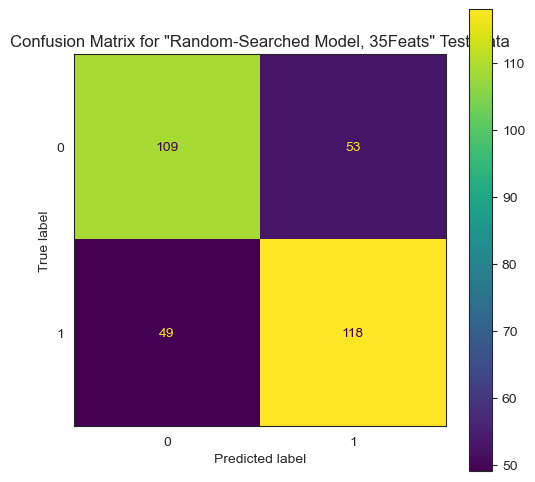

In [876]:
Model.model_list[-2].confusion_matrix()

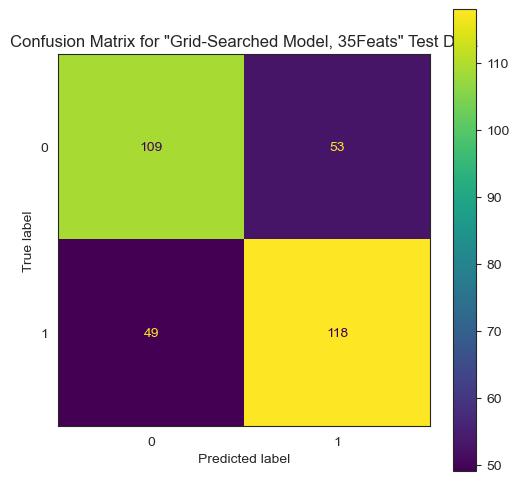

In [877]:
Model.model_list[-1].confusion_matrix()

<div class = "alert alert-info alert-block" style="font-size: 2em";>
    <b> Training on the Complete Dataframe </b>
    </div>
With the final hyperparameters selected, the final step is to retrain a model using those hyper-parameters on the full data set. Then, this model will be exported and used to predict match-ups for this year's Men's NCAA tournament.

In [936]:
# Pipeline

pipe_model = Pipeline(steps=[
    ("ct", ct),
    ("model", LogisticRegression(penalty="l2", max_iter=500, solver="liblinear", C=1))
])

pipe_model.fit(X[current_features], y)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9d23864610>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9d238645b0>)])),
                ('model',
                 LogisticRegression(C=1, max_iter=500, solver='liblinear'))])

In [937]:
# full_data_model = Model("Model Trained on All the Data", pipe_model, X_train, X_test, y_train, y_test)
full_data_model_500 = Model("Model Trained on All the Data, 500-MI/LIBLINEAR", pipe_model, X_train, X_test, y_train, y_test)


Model.model_df[21:].sort_values("test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.4s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
50,"Model Trained on All the Data, 500-MI/LIBLINEAR",0.720110,0.727507,0.713515,0.719456,0.539777,0.696049,0.698225,0.706587,0.702381,0.570448,0.769572
49,Model Trained on All the Data,0.718079,0.726516,0.709515,0.717001,0.540007,0.696049,0.698225,0.706587,0.702381,0.570474,0.769498
25,Men's RFC1 - diff+eff+ratings,0.685638,0.693459,0.677333,0.685052,0.556785,0.693009,0.691860,0.712575,0.702065,0.603494,0.738209
48,"Grid-Searched Model, 35Feats",0.720110,0.727507,0.713515,0.719456,0.539777,0.689970,0.690058,0.706587,0.698225,0.585990,0.754121
47,"Random-Searched Model, 35Feats",0.720110,0.727507,0.713515,0.719456,0.539777,0.689970,0.690058,0.706587,0.698225,0.585990,0.754121
...,...,...,...,...,...,...,...,...,...,...,...,...
23,Men's RFC1 - diff+eff,0.662293,0.663940,0.671354,0.667345,0.572735,0.665653,0.666667,0.682635,0.674556,0.608579,0.726843
24,Men's LR2 - diff+eff+ratings,0.700810,0.708023,0.695394,0.700728,0.551716,0.662614,0.659091,0.694611,0.676385,0.606671,0.739225
22,Men's LR1 - diff+eff,0.707932,0.714951,0.703414,0.708464,0.553428,0.659574,0.655367,0.694611,0.674419,0.602147,0.740963
27,Men's RFC4 - Top-27 Features,0.676506,0.679182,0.683374,0.681254,0.556888,0.659574,0.658960,0.682635,0.670588,0.596906,0.738116


In [938]:
# Extraction of coefficients
final_model_list = coefs_from_lr(full_data_model)

# Top-Ten Coefficients by magnitude
final_model_list[:10]

Top 5 Feature Coefficients by Absolute Value
('Int_MedPt_Diff_diff_x_Team_A_Def_diff_Team_B_Off', -1.6744399986193939)
('Int_MedPtDiff_diff_x_Avg_TO_diff', 1.4903504784400283)
('Int_Avg_Blocks_diff_x_StdPtDiff_diff', 1.1417933358318268)
('Team_A_Chalk_Seed', -1.0696338772954317)
('Team_A_WorstRanking', -1.0639056510824005)


[('Int_MedPt_Diff_diff_x_Team_A_Def_diff_Team_B_Off', -1.6744399986193939),
 ('Int_MedPtDiff_diff_x_Avg_TO_diff', 1.4903504784400283),
 ('Int_Avg_Blocks_diff_x_StdPtDiff_diff', 1.1417933358318268),
 ('Team_A_Chalk_Seed', -1.0696338772954317),
 ('Team_A_WorstRanking', -1.0639056510824005),
 ('Team_B_MedianRanking', 1.0285870286675227),
 ('Int_CloseWins_diff_x_close_game_win_perc_diff', 0.9902705088236179),
 ('Avg_Def_Rebs_diff', -0.9284526883602983),
 ('Chalk_Seed_diff', -0.9004880178969931),
 ('NetRating_diff', 0.8268662342151648)]

<div class = "alert alert-info alert-block" style="font-size: 2em";>
    <b> Saving the File </b>

In [939]:
from joblib import dump, load

In [943]:
# Import from the library
from joblib import dump, load

# Save the model to a file
dump(pipe_model, os.path.join(path, 'Trained_NCAA_Men_Model.joblib'))

['/Users/samalainabayeva/Desktop/FLAT_IRON!!!/NCAA_KAGGLE/march-machine-learning-mania-2024/Trained_NCAA_Men_Model.joblib']

##### Testing the loaded file

In [944]:
my_model = load(os.path.join(path, 'Trained_NCAA_Men_Model.joblib'))

In [945]:
my_model.predict_proba(X_test)[:5]

array([[0.40203834, 0.59796166],
       [0.06214569, 0.93785431],
       [0.33414805, 0.66585195],
       [0.22257665, 0.77742335],
       [0.66868998, 0.33131002]])

<hr style="border: 4px solid blue">

<div class = "alert alert-info alert-block" style="font-size: 2em; background-color:Blue; color:white";>
    <b> Conclusion </b>
    </div>
    
Throughout this notebook, I was tasked with attempting to improve predictive accuracy given a set of aggregated season statistics. I iterated through many models, ultimately choosing to create a model specifically for the Men's division. Even after restricting the data to the Men's league, the task of beating dummy logic still proved extremely difficult because of the lack of observations and statistics. 

After much evaluation, I found that Logistic Regression produced model predictions that were generally the best. There was one occasion in the process where a Random Forest Classifier produced exceptional results, however that was an instance where the RFC test score was actually *better* than the training score. I determined that this outcome was likely influenced by the specific data split, and I therefore opted to continue using Logistic Regression, as its results seemed more trustworthy.

I also attempted to reduce the number of features included, eventually arriving at 28 primary features that allowed me to outperform the dummy logic. These features were primarily based on the differences between the teams' aggregated season counting statistics, like average points/rebounds/assists. I then substantiated those features with 7 additional interaction terms. Each one of those terms did contribute to a bit of over-fitting, however the bottom-line improvement in performance for the final model made that a worthwhile trade-off. In fact, 3 different interaction terms had the largest magnitude of coefficients in the final Logistic Regression model, showing that they had the largest impact on classification and also confirming the value of their contribution to the model.
    
### Final Model Metrics Using the Same Split:
                      Dummy   |   Final Model
                 -----------------------------  
    - Accuracy  |   0.677812  |   0.696049
    - Precision |   0.672316  |   0.698225
    - Recall    |   0.712575  |   0.706587
    - F1 Score  |   0.691860  |   0.702381
    - Log-Loss  |   11.612849 |   0.570474


**After many model iterations,** I was able to squeeze out and additional 2% of accuracy. That may not seem like much, but it represents an objective improvement, and one that came through much effort and creativity. 

In [951]:
# 
full_data_model_500.X_train.columns

Index(['Chalk_Seed_diff', 'Team_A_MedianRanking', 'Team_B_MedianRanking',
       'Team_A_BestRanking', 'AvgPtDiff_diff', 'Team_B_BestRanking',
       'Team_B_WorstRanking', 'Team_A_WorstRanking', 'LastTenWinPerc_diff',
       'Team_B_Chalk_Seed', 'NetRating_diff', 'Team_A_Chalk_Seed',
       'Avg_Blocks_diff', 'Team_B_NetRating', 'AvgFGMade_diff',
       'MedPtDiff_diff', 'LastFiveWinPerc_diff', 'Avg_Steals_diff',
       'Team_A_Def_diff_Team_B_Off', 'Team_B_Off_Eff', 'Team_A_win_perc',
       'Team_B_win_perc', 'Team_A_Off_diff_Team_B_Def', 'Avg_Assts_diff',
       'Avg_Def_Rebs_diff', 'Avg_Off_Rebs_diff', 'Avg_TO_diff', 'Rebound_diff',
       'Int_Avg_Assts_diff_x_Avg_Steals_diff',
       'Int_MedPtDiff_diff_x_Avg_TO_diff',
       'Int_MedPt_Diff_diff_x_Team_A_Def_diff_Team_B_Off',
       'Int_Team_A_Off_diff_Team_B_Def_x_Avg_Off_Rebs_diff',
       'Int_Avg3ptAtt_diff_x_Avg3ptMade_diff',
       'Int_Avg_Blocks_diff_x_StdPtDiff_diff',
       'Int_CloseWins_diff_x_close_game_win_perc_d